In [31]:
# Model DLinear
from re import X
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = configs.individual
        self.channels = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()
            self.Linear_Decoder = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Trend.append(nn.Linear(self.seq_len,self.pred_len))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
                self.Linear_Decoder.append(nn.Linear(self.seq_len,self.pred_len))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Decoder = nn.Linear(self.seq_len,self.pred_len)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter((1/self.seq_len)*torch.ones([self.pred_len,self.seq_len]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.pred_len],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.pred_len],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

In [32]:
#TimeSeriesDataset class
from torch.utils.data import DataLoader, Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_len, pred_len):
        self.data = data
        self.seq_len = seq_len
        self.pred_len = pred_len

    def __len__(self):
        return len(self.data) - self.seq_len - self.pred_len + 1

    def __getitem__(self, index):
        x = self.data[index : index + self.seq_len]
        y = self.data[index + self.seq_len : index + self.seq_len + self.pred_len]
       
        return x, y

In [33]:
#fit function
def fit(model, train_data, test_data, seq_len, pred_len, batch_size, num_epochs, learning_rate):
    # Create DataLoaders
    train_dataset = TimeSeriesDataset(train_data, seq_len, pred_len)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TimeSeriesDataset(test_data, seq_len, pred_len)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        loop = tqdm(train_loader, leave=True)

        for i, (batch_x, batch_y) in enumerate(train_loader):
            optimizer.zero_grad()

            batch_x = batch_x.float()
            batch_y = batch_y.float()
            output = model(batch_x)

            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            loop.set_description(f'Epoch [{epoch}/{num_epochs}]')
            loop.set_postfix(loss=loss.item())

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (batch_x, batch_y) in enumerate(test_loader):
                batch_x = batch_x.float()
                batch_y = batch_y.float()
                output = model(batch_x)
                loss = criterion(output, batch_y)
                test_loss += loss.item()

        scheduler.step(test_loss)  # Update learning rate based on test loss

        train_loss /= len(train_loader)
        test_loss /= len(test_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return model

In [34]:
def predict_test(model, test_data, seq_len, pred_len, batch_size):
    test_dataset = TimeSeriesDataset(test_data, seq_len, pred_len)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # Initialize an empty list to store the predictions
    test_pred = []

    # Iterate over the test data
    for i, (batch_x, batch_y) in enumerate(test_loader):
        batch_x = batch_x.float()
        batch_y = batch_y.float()

        # Make predictions
        with torch.no_grad():
            output = model(batch_x)

        # Append the predictions to the list
        test_pred.append(output)

    # Concatenate the predictions into a single tensor
    test_pred_tensor = torch.cat(test_pred, dim=0)

    # Select the last prediction from each sequence
    test_pred_1 = test_pred_tensor[:, -1, :]

    # Detach and convert to numpy array
    test_pred_1 = test_pred_1.detach().cpu().numpy()

    # Inverse transform the predictions

    return test_pred_1

In [35]:
#predict xx days function
def predict(model, test_data, seq_len, prediction_days=30):
    # Lấy những phần tử cuối cùng có độ dài seq_len
    last_days = test_data[-seq_len:]
    # Chuyển đổi thành tensor và thêm một chiều
    input_x = torch.tensor(last_days).float().unsqueeze(0)
    # Khởi tạo một danh sách để lưu trữ các dự đoán
    predictions = []

    for _ in range(prediction_days):
        with torch.no_grad():
            # Dự đoán cho ngày tiếp theo
            output = model(input_x)
            
            # Lấy dự đoán cuối cùng
            last_output = output[:, -1, :]
            
            # Thêm dự đoán vào danh sách
            predictions.append(last_output)
            
            # Thêm dự đoán vào input cho bước tiếp theo
            input_x = torch.cat((input_x[:, 1:, :], last_output.unsqueeze(0)), dim=1)

    # Chuyển đổi danh sách dự đoán thành tensor
    predictions_tensor = torch.cat(predictions, dim=0)

    return predictions_tensor

In [36]:
#read data
import pandas as pd
# Đọc dữ liệu từ file CSV
## HaNoi
df_Hanoi = pd.read_csv('data/AQI_Hanoi_Done.csv')
df1_HaNoi=df_Hanoi.reset_index()['AQI']

## DaNang
df_DaNang = pd.read_csv('data/AQI_DaNang_Done.csv')
df1_DaNang=df_DaNang.reset_index()['AQI']

## VietTri
df_VietTri = pd.read_csv('data/AQI_VietTri_Done.csv')
df1_VietTri=df_VietTri.reset_index()['AQI']

In [37]:
# Scaler data
from sklearn.preprocessing import MinMaxScaler
import numpy as np
scaler=MinMaxScaler(feature_range=(0,1))

df1_HaNoi =scaler.fit_transform(np.array(df1_HaNoi).reshape(-1,1))
df1_DaNang =scaler.fit_transform(np.array(df1_DaNang).reshape(-1,1))
df1_VietTri =scaler.fit_transform(np.array(df1_VietTri).reshape(-1,1))


In [38]:
class Configs:
    enc_in = 1
    dec_in = 1
    seq_len = 48
    label_len = 24
    pred_len = 24
    individual = False
configs = Configs()
model = Model(configs)

### Với tỉ lệ 7 - 3

In [39]:
#splitting dataset into train and test split
split_size = 0.7

## HaNoi
train_size= int(split_size * len(df_Hanoi))
test_size = int((1-split_size) * len(df_Hanoi))

train_data_HaNoi = df1_HaNoi[:train_size]
test_data_HaNoi = df1_HaNoi[train_size:train_size+test_size]

## DaNang
train_size= int(split_size * len(df_DaNang))
test_size = int((1-split_size) * len(df_DaNang))

train_data_DaNang = df1_DaNang[:train_size]
test_data_DaNang = df1_DaNang[train_size:train_size+test_size]

## VietTri
train_size= int(split_size * len(df_VietTri))
test_size = int((1-split_size) * len(df_VietTri))

train_data_VietTri = df1_VietTri[:train_size]
test_data_VietTri = df1_VietTri[train_size:train_size+test_size]



In [40]:
#train model
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
# Hyperparameters
seq_len = configs.seq_len  
pred_len =  configs.pred_len
batch_size = 64
num_epochs = 100
learning_rate = 0.003
individual = False


#fit model for HaNoi
model_HaNoi = fit(model, train_data_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for DaNang
model_DaNang = fit(model, train_data_DaNang, test_data_DaNang, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for VietTri
model_VietTri = fit(model, train_data_VietTri, test_data_VietTri, seq_len, pred_len, batch_size, num_epochs, learning_rate)


c:\Users\Hung\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [0/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0269]

Epoch 1/100, Train Loss: 0.0318, Test Loss: 0.0303


Epoch [0/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0269]


Epoch 2/100, Train Loss: 0.0274, Test Loss: 0.0274


Epoch [2/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0219]

Epoch 3/100, Train Loss: 0.0257, Test Loss: 0.0283


Epoch [2/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0219]


Epoch 4/100, Train Loss: 0.0250, Test Loss: 0.0279


Epoch [4/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0228]

Epoch 5/100, Train Loss: 0.0245, Test Loss: 0.0294


Epoch [4/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0228]


Epoch 6/100, Train Loss: 0.0246, Test Loss: 0.0265


Epoch [6/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.026] 

Epoch 7/100, Train Loss: 0.0244, Test Loss: 0.0271


Epoch [6/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.026]


Epoch 8/100, Train Loss: 0.0245, Test Loss: 0.0285


Epoch [8/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0283]

Epoch 9/100, Train Loss: 0.0245, Test Loss: 0.0276


Epoch [8/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0283]


Epoch 10/100, Train Loss: 0.0244, Test Loss: 0.0265


Epoch [10/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0233]

Epoch 11/100, Train Loss: 0.0244, Test Loss: 0.0265


Epoch [10/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0233]


Epoch 12/100, Train Loss: 0.0244, Test Loss: 0.0270


Epoch [12/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0235]

Epoch 13/100, Train Loss: 0.0245, Test Loss: 0.0272


Epoch [12/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0235]


Epoch 14/100, Train Loss: 0.0248, Test Loss: 0.0273


Epoch [14/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0256]

Epoch 15/100, Train Loss: 0.0244, Test Loss: 0.0275


Epoch [14/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0256]


Epoch 16/100, Train Loss: 0.0243, Test Loss: 0.0283


Epoch [16/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0219]

Epoch 17/100, Train Loss: 0.0241, Test Loss: 0.0275


Epoch [16/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0219]


Epoch 18/100, Train Loss: 0.0241, Test Loss: 0.0288


Epoch [18/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0275]

Epoch 19/100, Train Loss: 0.0242, Test Loss: 0.0271


Epoch [18/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0275]


Epoch 20/100, Train Loss: 0.0242, Test Loss: 0.0276


Epoch [20/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0275]

Epoch 21/100, Train Loss: 0.0242, Test Loss: 0.0289


Epoch [20/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0275]


Epoch 22/100, Train Loss: 0.0241, Test Loss: 0.0272


Epoch [22/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0267]

Epoch 23/100, Train Loss: 0.0240, Test Loss: 0.0278


Epoch [22/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0267]


Epoch 24/100, Train Loss: 0.0239, Test Loss: 0.0274


Epoch [24/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0244]

Epoch 25/100, Train Loss: 0.0240, Test Loss: 0.0270


Epoch [24/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0244]


Epoch 26/100, Train Loss: 0.0240, Test Loss: 0.0264


Epoch [26/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0225]

Epoch 27/100, Train Loss: 0.0240, Test Loss: 0.0278


Epoch [26/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0225]


Epoch 28/100, Train Loss: 0.0241, Test Loss: 0.0275


Epoch [28/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0297]

Epoch 29/100, Train Loss: 0.0241, Test Loss: 0.0273


Epoch [28/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0297]


Epoch 30/100, Train Loss: 0.0240, Test Loss: 0.0268


Epoch [30/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.024] 

Epoch 31/100, Train Loss: 0.0240, Test Loss: 0.0276


Epoch [30/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.024]


Epoch 32/100, Train Loss: 0.0240, Test Loss: 0.0279


Epoch [32/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0291]

Epoch 33/100, Train Loss: 0.0241, Test Loss: 0.0270


Epoch [32/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0291]


Epoch 34/100, Train Loss: 0.0239, Test Loss: 0.0275


Epoch [34/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0193]

Epoch 35/100, Train Loss: 0.0238, Test Loss: 0.0271


Epoch [34/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0193]


Epoch 36/100, Train Loss: 0.0239, Test Loss: 0.0271


Epoch [36/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0215]

Epoch 37/100, Train Loss: 0.0238, Test Loss: 0.0279


Epoch [36/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0215]


Epoch 38/100, Train Loss: 0.0240, Test Loss: 0.0269


Epoch [38/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0205]

Epoch 39/100, Train Loss: 0.0238, Test Loss: 0.0274


Epoch [38/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0205]


Epoch 40/100, Train Loss: 0.0239, Test Loss: 0.0272


Epoch [40/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0219]

Epoch 41/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [40/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0219]


Epoch 42/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [42/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0223]

Epoch 43/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [42/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0223]


Epoch 44/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [44/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0219]

Epoch 45/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [44/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0219]


Epoch 46/100, Train Loss: 0.0238, Test Loss: 0.0274


Epoch [46/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0213]

Epoch 47/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [46/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0213]


Epoch 48/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [48/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.024] 

Epoch 49/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [48/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.024]


Epoch 50/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [50/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0191]

Epoch 51/100, Train Loss: 0.0237, Test Loss: 0.0274


Epoch [50/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0191]


Epoch 52/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [52/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0188]

Epoch 53/100, Train Loss: 0.0237, Test Loss: 0.0272


Epoch [52/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0188]


Epoch 54/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [54/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0243]

Epoch 55/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [54/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0243]


Epoch 56/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [56/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.024] 

Epoch 57/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [56/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.024]


Epoch 58/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [58/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0201]

Epoch 59/100, Train Loss: 0.0237, Test Loss: 0.0273


Epoch [58/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0201]


Epoch 60/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [60/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0237]

Epoch 61/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [60/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0237]


Epoch 62/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [62/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0228]

Epoch 63/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [62/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0228]


Epoch 64/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [64/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0266]

Epoch 65/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [64/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0266]


Epoch 66/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [66/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0301]

Epoch 67/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [66/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0301]


Epoch 68/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [68/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0222]

Epoch 69/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [68/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0222]


Epoch 70/100, Train Loss: 0.0238, Test Loss: 0.0272


Epoch [70/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0267]

Epoch 71/100, Train Loss: 0.0239, Test Loss: 0.0272


Epoch [70/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0267]


Epoch 72/100, Train Loss: 0.0237, Test Loss: 0.0273


Epoch [72/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0224]

Epoch 73/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [72/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0224]


Epoch 74/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [74/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0274]

Epoch 75/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [74/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0274]


Epoch 76/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [76/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0234]

Epoch 77/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [76/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0234]


Epoch 78/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [78/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0263]

Epoch 79/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [78/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0263]


Epoch 80/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [80/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0292]

Epoch 81/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [80/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0292]


Epoch 82/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [82/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.024] 

Epoch 83/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [82/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.024]


Epoch 84/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [84/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0265]

Epoch 85/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [84/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0265]


Epoch 86/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [86/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0215]

Epoch 87/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [86/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0215]


Epoch 88/100, Train Loss: 0.0237, Test Loss: 0.0273


Epoch [88/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0242]

Epoch 89/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [88/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0242]


Epoch 90/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [90/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0249]

Epoch 91/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [90/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0249]


Epoch 92/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [92/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0242]

Epoch 93/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [92/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0242]


Epoch 94/100, Train Loss: 0.0237, Test Loss: 0.0273


Epoch [94/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.026] 

Epoch 95/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [94/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.026]


Epoch 96/100, Train Loss: 0.0238, Test Loss: 0.0273


Epoch [96/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0202]

Epoch 97/100, Train Loss: 0.0237, Test Loss: 0.0273


Epoch [96/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0202]


Epoch 98/100, Train Loss: 0.0237, Test Loss: 0.0273


Epoch [98/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0194]

Epoch 99/100, Train Loss: 0.0237, Test Loss: 0.0273


Epoch [99/100]:   0%|          | 0/21 [00:00<?, ?it/s, loss=0.0267]


Epoch 100/100, Train Loss: 0.0239, Test Loss: 0.0273


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0106] 

Epoch 1/100, Train Loss: 0.0115, Test Loss: 0.0234


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0106]


Epoch 2/100, Train Loss: 0.0107, Test Loss: 0.0235


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0119] 

Epoch 3/100, Train Loss: 0.0105, Test Loss: 0.0228


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0119]


Epoch 4/100, Train Loss: 0.0104, Test Loss: 0.0233


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00978]

Epoch 5/100, Train Loss: 0.0104, Test Loss: 0.0232


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00978]


Epoch 6/100, Train Loss: 0.0104, Test Loss: 0.0233


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112] 

Epoch 7/100, Train Loss: 0.0103, Test Loss: 0.0232


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112]


Epoch 8/100, Train Loss: 0.0103, Test Loss: 0.0228


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0109] 

Epoch 9/100, Train Loss: 0.0105, Test Loss: 0.0232


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0109]


Epoch 10/100, Train Loss: 0.0104, Test Loss: 0.0230


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0126] 

Epoch 11/100, Train Loss: 0.0105, Test Loss: 0.0232


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0126]


Epoch 12/100, Train Loss: 0.0106, Test Loss: 0.0242


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0199] 

Epoch 13/100, Train Loss: 0.0108, Test Loss: 0.0228


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0199]


Epoch 14/100, Train Loss: 0.0104, Test Loss: 0.0232


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00973]

Epoch 15/100, Train Loss: 0.0103, Test Loss: 0.0233


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00973]


Epoch 16/100, Train Loss: 0.0103, Test Loss: 0.0228


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0123] 

Epoch 17/100, Train Loss: 0.0104, Test Loss: 0.0232


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0123]


Epoch 18/100, Train Loss: 0.0103, Test Loss: 0.0233


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0118] 

Epoch 19/100, Train Loss: 0.0104, Test Loss: 0.0230


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0118]


Epoch 20/100, Train Loss: 0.0103, Test Loss: 0.0230


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00798]

Epoch 21/100, Train Loss: 0.0102, Test Loss: 0.0231


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00798]


Epoch 22/100, Train Loss: 0.0101, Test Loss: 0.0228


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0106] 

Epoch 23/100, Train Loss: 0.0103, Test Loss: 0.0227


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0106]


Epoch 24/100, Train Loss: 0.0103, Test Loss: 0.0230


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102] 

Epoch 25/100, Train Loss: 0.0102, Test Loss: 0.0232


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102]


Epoch 26/100, Train Loss: 0.0103, Test Loss: 0.0231


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00842]

Epoch 27/100, Train Loss: 0.0102, Test Loss: 0.0229


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00842]


Epoch 28/100, Train Loss: 0.0102, Test Loss: 0.0231


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0108] 

Epoch 29/100, Train Loss: 0.0103, Test Loss: 0.0231


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0108]


Epoch 30/100, Train Loss: 0.0101, Test Loss: 0.0230


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00978]

Epoch 31/100, Train Loss: 0.0102, Test Loss: 0.0229


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00978]


Epoch 32/100, Train Loss: 0.0102, Test Loss: 0.0235


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104] 

Epoch 33/100, Train Loss: 0.0102, Test Loss: 0.0230


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0104]


Epoch 34/100, Train Loss: 0.0102, Test Loss: 0.0233


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0115] 

Epoch 35/100, Train Loss: 0.0102, Test Loss: 0.0229


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0115]


Epoch 36/100, Train Loss: 0.0101, Test Loss: 0.0232


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0114] 

Epoch 37/100, Train Loss: 0.0102, Test Loss: 0.0231


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0114]


Epoch 38/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00842]

Epoch 39/100, Train Loss: 0.0101, Test Loss: 0.0232


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00842]


Epoch 40/100, Train Loss: 0.0102, Test Loss: 0.0230


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0126] 

Epoch 41/100, Train Loss: 0.0102, Test Loss: 0.0231


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0126]


Epoch 42/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102] 

Epoch 43/100, Train Loss: 0.0101, Test Loss: 0.0230


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102]


Epoch 44/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0115] 

Epoch 45/100, Train Loss: 0.0102, Test Loss: 0.0231


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0115]


Epoch 46/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00894]

Epoch 47/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00894]


Epoch 48/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0125] 

Epoch 49/100, Train Loss: 0.0102, Test Loss: 0.0231


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0125]


Epoch 50/100, Train Loss: 0.0100, Test Loss: 0.0231


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00817]

Epoch 51/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00817]


Epoch 52/100, Train Loss: 0.0101, Test Loss: 0.0230


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0143] 

Epoch 53/100, Train Loss: 0.0102, Test Loss: 0.0231


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0143]


Epoch 54/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102] 

Epoch 55/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0102]


Epoch 56/100, Train Loss: 0.0100, Test Loss: 0.0231


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0122] 

Epoch 57/100, Train Loss: 0.0102, Test Loss: 0.0231


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0122]


Epoch 58/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0106] 

Epoch 59/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0106]


Epoch 60/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112] 

Epoch 61/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112]


Epoch 62/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0116] 

Epoch 63/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0116]


Epoch 64/100, Train Loss: 0.0102, Test Loss: 0.0230


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00921]

Epoch 65/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00921]


Epoch 66/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00754]

Epoch 67/100, Train Loss: 0.0100, Test Loss: 0.0231


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00754]


Epoch 68/100, Train Loss: 0.0100, Test Loss: 0.0231


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0101] 

Epoch 69/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0101]


Epoch 70/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00929]

Epoch 71/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00929]


Epoch 72/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112] 

Epoch 73/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0112]


Epoch 74/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.012]  

Epoch 75/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.012]


Epoch 76/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0105] 

Epoch 77/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0105]


Epoch 78/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0111] 

Epoch 79/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0111]


Epoch 80/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0113] 

Epoch 81/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0113]


Epoch 82/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.011]  

Epoch 83/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.011]


Epoch 84/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00817]

Epoch 85/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00817]


Epoch 86/100, Train Loss: 0.0102, Test Loss: 0.0231


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0123] 

Epoch 87/100, Train Loss: 0.0102, Test Loss: 0.0231


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0123]


Epoch 88/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0111] 

Epoch 89/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0111]


Epoch 90/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0108] 

Epoch 91/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0108]


Epoch 92/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00814]

Epoch 93/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00814]


Epoch 94/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00845]

Epoch 95/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00845]


Epoch 96/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00733]

Epoch 97/100, Train Loss: 0.0100, Test Loss: 0.0231


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00733]


Epoch 98/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [98/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00975]

Epoch 99/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [99/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.00988]


Epoch 100/100, Train Loss: 0.0101, Test Loss: 0.0231


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0278]

Epoch 1/100, Train Loss: 0.0254, Test Loss: 0.0257


Epoch [0/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0278]


Epoch 2/100, Train Loss: 0.0239, Test Loss: 0.0251


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0212]

Epoch 3/100, Train Loss: 0.0234, Test Loss: 0.0253


Epoch [2/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0212]


Epoch 4/100, Train Loss: 0.0232, Test Loss: 0.0244


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0221]

Epoch 5/100, Train Loss: 0.0230, Test Loss: 0.0246


Epoch [4/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0221]


Epoch 6/100, Train Loss: 0.0235, Test Loss: 0.0246


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0253]

Epoch 7/100, Train Loss: 0.0231, Test Loss: 0.0244


Epoch [6/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0253]


Epoch 8/100, Train Loss: 0.0230, Test Loss: 0.0248


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0269]

Epoch 9/100, Train Loss: 0.0232, Test Loss: 0.0249


Epoch [8/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0269]


Epoch 10/100, Train Loss: 0.0228, Test Loss: 0.0253


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0229]

Epoch 11/100, Train Loss: 0.0234, Test Loss: 0.0252


Epoch [10/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0229]


Epoch 12/100, Train Loss: 0.0230, Test Loss: 0.0246


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0183]

Epoch 13/100, Train Loss: 0.0229, Test Loss: 0.0246


Epoch [12/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0183]


Epoch 14/100, Train Loss: 0.0227, Test Loss: 0.0246


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0187]

Epoch 15/100, Train Loss: 0.0226, Test Loss: 0.0245


Epoch [14/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0187]


Epoch 16/100, Train Loss: 0.0227, Test Loss: 0.0250


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0214]

Epoch 17/100, Train Loss: 0.0230, Test Loss: 0.0248


Epoch [16/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0214]


Epoch 18/100, Train Loss: 0.0229, Test Loss: 0.0255


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0214]

Epoch 19/100, Train Loss: 0.0229, Test Loss: 0.0254


Epoch [18/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0214]


Epoch 20/100, Train Loss: 0.0228, Test Loss: 0.0246


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.029] 

Epoch 21/100, Train Loss: 0.0228, Test Loss: 0.0250


Epoch [20/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.029]


Epoch 22/100, Train Loss: 0.0226, Test Loss: 0.0247


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.019] 

Epoch 23/100, Train Loss: 0.0225, Test Loss: 0.0248


Epoch [22/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.019]


Epoch 24/100, Train Loss: 0.0226, Test Loss: 0.0251


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0213]

Epoch 25/100, Train Loss: 0.0227, Test Loss: 0.0245


Epoch [24/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0213]


Epoch 26/100, Train Loss: 0.0227, Test Loss: 0.0246


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0271]

Epoch 27/100, Train Loss: 0.0227, Test Loss: 0.0245


Epoch [26/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0271]


Epoch 28/100, Train Loss: 0.0227, Test Loss: 0.0246


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0228]

Epoch 29/100, Train Loss: 0.0226, Test Loss: 0.0246


Epoch [28/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0228]


Epoch 30/100, Train Loss: 0.0225, Test Loss: 0.0244


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0328]

Epoch 31/100, Train Loss: 0.0228, Test Loss: 0.0246


Epoch [30/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0328]


Epoch 32/100, Train Loss: 0.0226, Test Loss: 0.0245


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0249]

Epoch 33/100, Train Loss: 0.0226, Test Loss: 0.0246


Epoch [32/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0249]


Epoch 34/100, Train Loss: 0.0226, Test Loss: 0.0245


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0221]

Epoch 35/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [34/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0221]


Epoch 36/100, Train Loss: 0.0229, Test Loss: 0.0245


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0254]

Epoch 37/100, Train Loss: 0.0226, Test Loss: 0.0245


Epoch [36/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0254]


Epoch 38/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0262]

Epoch 39/100, Train Loss: 0.0226, Test Loss: 0.0245


Epoch [38/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0262]


Epoch 40/100, Train Loss: 0.0225, Test Loss: 0.0246


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0258]

Epoch 41/100, Train Loss: 0.0226, Test Loss: 0.0245


Epoch [40/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0258]


Epoch 42/100, Train Loss: 0.0223, Test Loss: 0.0245


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0213]

Epoch 43/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [42/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0213]


Epoch 44/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0184]

Epoch 45/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [44/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0184]


Epoch 46/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0197]

Epoch 47/100, Train Loss: 0.0224, Test Loss: 0.0246


Epoch [46/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0197]


Epoch 48/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0202]

Epoch 49/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [48/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0202]


Epoch 50/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0163]

Epoch 51/100, Train Loss: 0.0223, Test Loss: 0.0245


Epoch [50/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0163]


Epoch 52/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0261]

Epoch 53/100, Train Loss: 0.0226, Test Loss: 0.0245


Epoch [52/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0261]


Epoch 54/100, Train Loss: 0.0223, Test Loss: 0.0245


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0228]

Epoch 55/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [54/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0228]


Epoch 56/100, Train Loss: 0.0227, Test Loss: 0.0245


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0235]

Epoch 57/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [56/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0235]


Epoch 58/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0207]

Epoch 59/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [58/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0207]


Epoch 60/100, Train Loss: 0.0227, Test Loss: 0.0245


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0218]

Epoch 61/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [60/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0218]


Epoch 62/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0223]

Epoch 63/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [62/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0223]


Epoch 64/100, Train Loss: 0.0226, Test Loss: 0.0245


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0172]

Epoch 65/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [64/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0172]


Epoch 66/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0208]

Epoch 67/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [66/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0208]


Epoch 68/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0212]

Epoch 69/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [68/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0212]


Epoch 70/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0152]

Epoch 71/100, Train Loss: 0.0223, Test Loss: 0.0245


Epoch [70/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0152]


Epoch 72/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.029] 

Epoch 73/100, Train Loss: 0.0226, Test Loss: 0.0245


Epoch [72/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.029]


Epoch 74/100, Train Loss: 0.0223, Test Loss: 0.0245


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.017] 

Epoch 75/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [74/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.017]


Epoch 76/100, Train Loss: 0.0223, Test Loss: 0.0245


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0225]

Epoch 77/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [76/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0225]


Epoch 78/100, Train Loss: 0.0226, Test Loss: 0.0245


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0232]

Epoch 79/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [78/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0232]


Epoch 80/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0243]

Epoch 81/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [80/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0243]


Epoch 82/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0221]

Epoch 83/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [82/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0221]


Epoch 84/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0243]

Epoch 85/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [84/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0243]


Epoch 86/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0179]

Epoch 87/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [86/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0179]


Epoch 88/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0222]

Epoch 89/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [88/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0222]


Epoch 90/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0182]

Epoch 91/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [90/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0182]


Epoch 92/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0207]

Epoch 93/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [92/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0207]


Epoch 94/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0212]

Epoch 95/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [94/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0212]


Epoch 96/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0173]

Epoch 97/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [96/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0173]


Epoch 98/100, Train Loss: 0.0225, Test Loss: 0.0245


Epoch [98/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0195]

Epoch 99/100, Train Loss: 0.0224, Test Loss: 0.0245


Epoch [99/100]:   0%|          | 0/20 [00:00<?, ?it/s, loss=0.0221]

Epoch 100/100, Train Loss: 0.0225, Test Loss: 0.0245


In [41]:
# Make predictions on the test data
test_pred_HaNoi = predict_test(model_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size)
test_pred_DaNang = predict_test(model_DaNang, test_data_DaNang, seq_len, pred_len, batch_size)
test_pred_VietTri = predict_test(model_VietTri, test_data_VietTri, seq_len, pred_len, batch_size)
# Inverse transform the predictions
test_pred_HaNoi = scaler.inverse_transform(test_pred_HaNoi)
test_pred_DaNang = scaler.inverse_transform(test_pred_DaNang)
test_pred_VietTri = scaler.inverse_transform(test_pred_VietTri)
print(test_pred_HaNoi)


[[ 55.640945]
 [ 45.698757]
 [ 52.767765]
 [ 66.45585 ]
 [ 71.220634]
 [ 65.30901 ]
 [ 69.92279 ]
 [ 63.7945  ]
 [ 58.39933 ]
 [ 68.30528 ]
 [ 74.21708 ]
 [ 72.64942 ]
 [ 71.04357 ]
 [ 75.94644 ]
 [ 73.01263 ]
 [ 68.166084]
 [ 71.680016]
 [ 79.418365]
 [ 77.99354 ]
 [ 83.753494]
 [ 77.36051 ]
 [ 70.71341 ]
 [ 77.803116]
 [ 77.74275 ]
 [ 71.083725]
 [ 72.67894 ]
 [ 83.5436  ]
 [ 87.93366 ]
 [ 93.227036]
 [ 92.18484 ]
 [102.73759 ]
 [ 92.411285]
 [106.88151 ]
 [119.39493 ]
 [117.211525]
 [117.243385]
 [127.194565]
 [133.26501 ]
 [136.97691 ]
 [133.81793 ]
 [118.22397 ]
 [126.59433 ]
 [132.91475 ]
 [133.46686 ]
 [119.20512 ]
 [129.3581  ]
 [136.06787 ]
 [141.03362 ]
 [144.71088 ]
 [146.7866  ]
 [145.5848  ]
 [134.65456 ]
 [123.99441 ]
 [132.7146  ]
 [143.00835 ]
 [144.86073 ]
 [150.42839 ]
 [140.75879 ]
 [132.86092 ]
 [125.030075]
 [122.96789 ]
 [115.200645]
 [102.53595 ]
 [107.66953 ]
 [117.058815]
 [116.56069 ]
 [115.63712 ]
 [110.46393 ]
 [ 87.606514]
 [ 77.0998  ]
 [ 77.07135 ]
 [ 78.

In [42]:
## Make predictions for the next 30 days
prediction_days = 30
predictions_HaNoi_30 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_30 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_30 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_30 = scaler.inverse_transform(predictions_HaNoi_30)
predictions_DaNang_30 = scaler.inverse_transform(predictions_DaNang_30)
predictions_VietTri_30 = scaler.inverse_transform(predictions_VietTri_30)

## Make predictions for the next 60 days
prediction_days = 60
predictions_HaNoi_60 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_60 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_60 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_60 = scaler.inverse_transform(predictions_HaNoi_60)
predictions_DaNang_60 = scaler.inverse_transform(predictions_DaNang_60)
predictions_VietTri_60 = scaler.inverse_transform(predictions_VietTri_60)

## Make predictions for the next 90 days

prediction_days = 90
predictions_HaNoi_90 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_90 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_90 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_90 = scaler.inverse_transform(predictions_HaNoi_90)
predictions_DaNang_90 = scaler.inverse_transform(predictions_DaNang_90)
predictions_VietTri_90 = scaler.inverse_transform(predictions_VietTri_90)


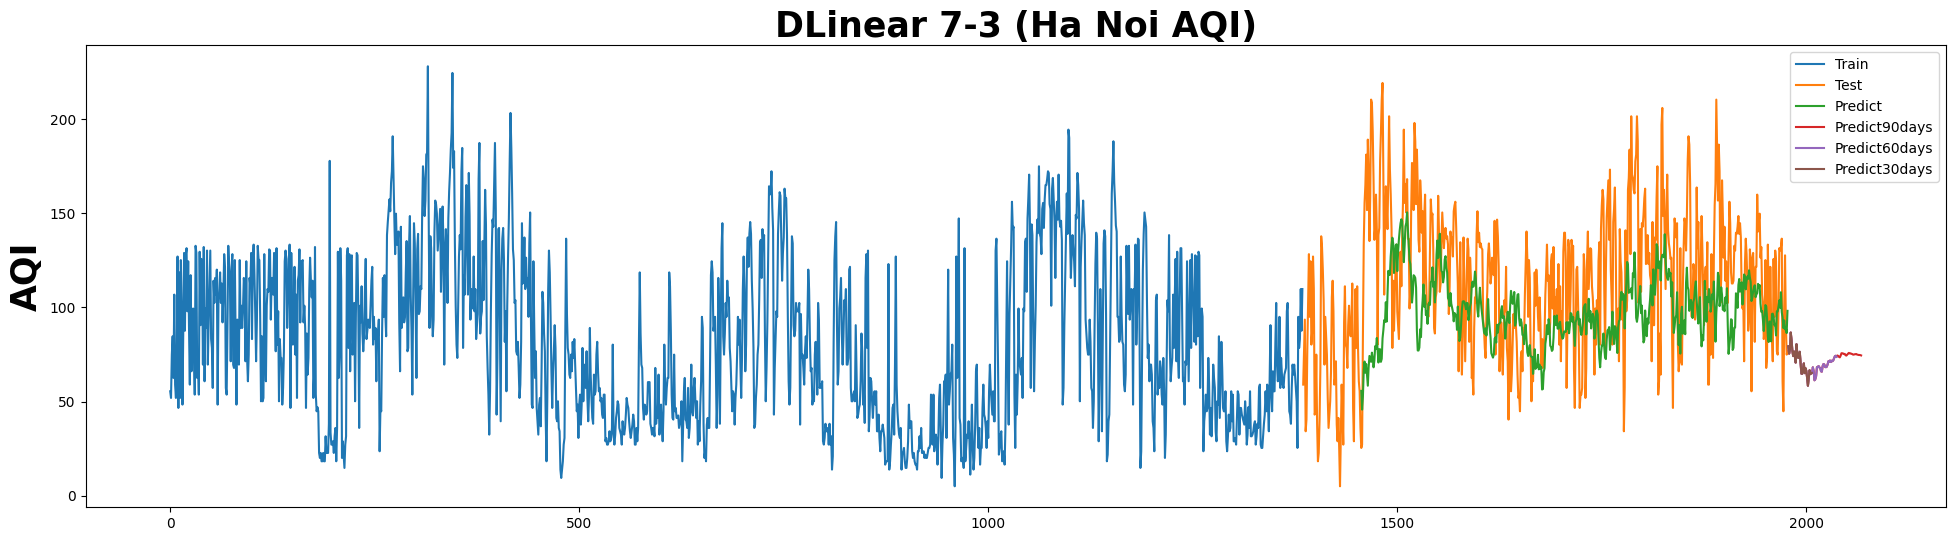

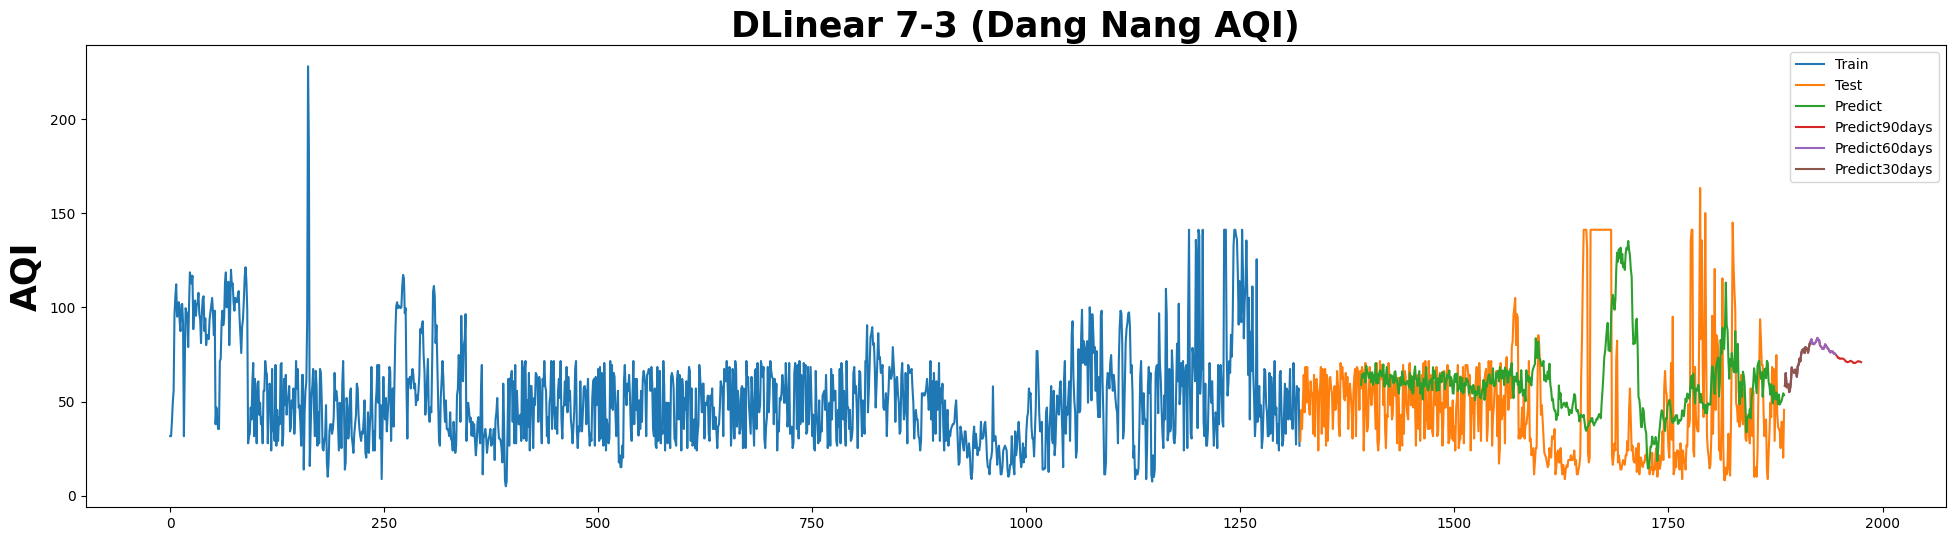

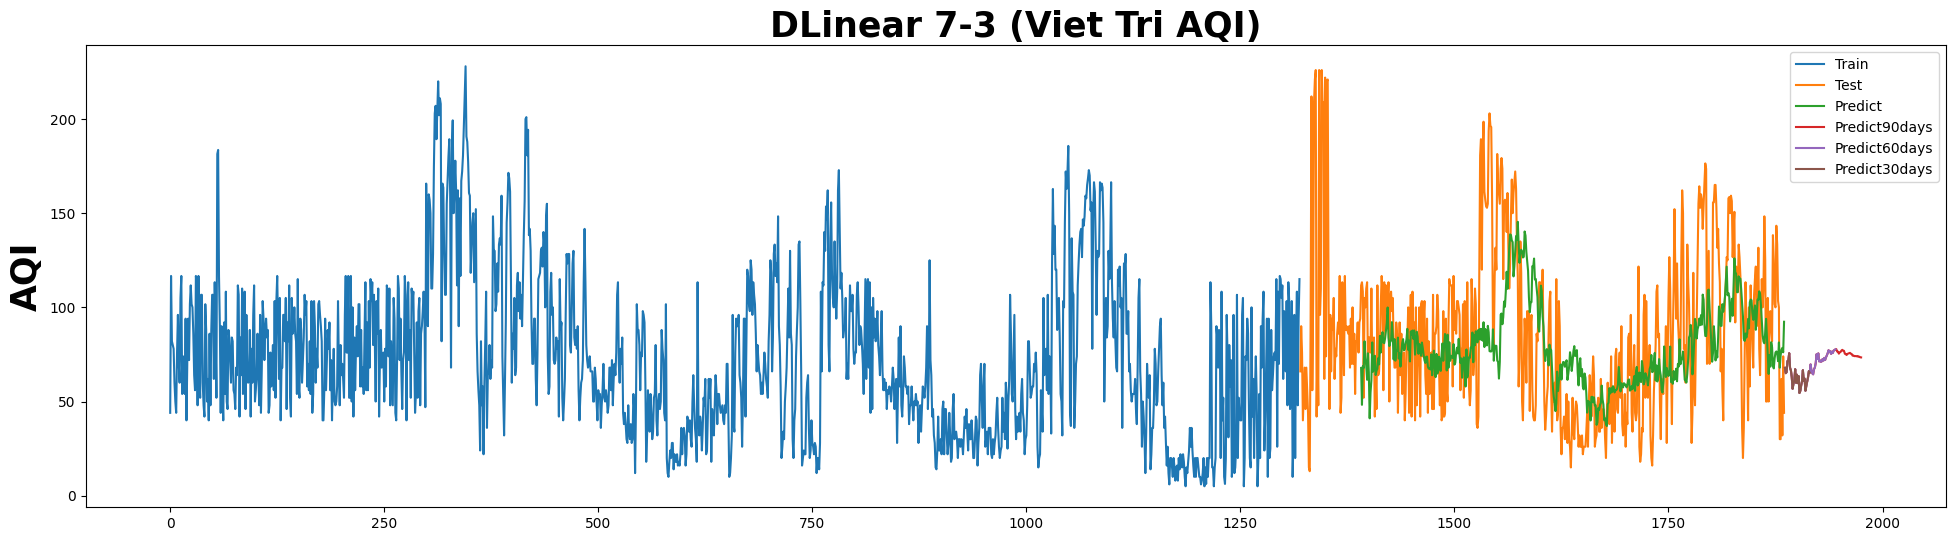

In [43]:
# Visualize the predictions
import matplotlib.pyplot as plt

## HaNoi
train_data_origin = scaler.inverse_transform(train_data_HaNoi)
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi
pred_30_origin = predictions_HaNoi_30
pred_60_origin = predictions_HaNoi_60
pred_90_origin = predictions_HaNoi_90


test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 7-3 (Ha Noi AQI)', fontsize=25, fontweight='bold')
plt.ylabel('AQI', fontsize=25, fontweight='bold')

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])

#Save plot to file
plt.savefig('plot/DLinear_7-3_HaNoi.png')

## DaNang
train_data_origin = scaler.inverse_transform(train_data_DaNang)
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang
pred_30_origin = predictions_DaNang_30
pred_60_origin = predictions_DaNang_60
pred_90_origin = predictions_DaNang_90

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 7-3 (Dang Nang AQI)', fontsize=25, fontweight='bold')
plt.ylabel('AQI', fontsize=25, fontweight='bold')

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_7-3_DaNang.png')

## VietTri
train_data_origin = scaler.inverse_transform(train_data_VietTri)
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri
pred_30_origin = predictions_VietTri_30
pred_60_origin = predictions_VietTri_60
pred_90_origin = predictions_VietTri_90

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 7-3 (Viet Tri AQI)', fontsize=25, fontweight='bold')
plt.ylabel('AQI', fontsize=25, fontweight='bold')

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])

#Save plot to file
plt.savefig('plot/DLinear_7-3_VietTri.png')



In [44]:
#tính RMSE,MAPE,MAE cho tâp test
from sklearn.metrics import mean_squared_error
from math import sqrt

## HaNoi
print('HaNoi')
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

print('DaNang')
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

## VietTri
print('VietTri')
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)


HaNoi
Test RMSE: 42.807
Test MAPE: 29.020
Test MAE: 34.242
DaNang
Test RMSE: 41.167
Test MAPE: 107.026
Test MAE: 30.415
VietTri
Test RMSE: 38.331
Test MAPE: 45.107
Test MAE: 30.089


### Với tỉ lệ 8 - 2

In [45]:
#splitting dataset into train and test split
split_size = 0.8

## HaNoi
train_size= int(split_size * len(df_Hanoi))
test_size = int((1-split_size) * len(df_Hanoi))

train_data_HaNoi = df1_HaNoi[:train_size]
test_data_HaNoi = df1_HaNoi[train_size:train_size+test_size]

## DaNang
train_size= int(split_size * len(df_DaNang))
test_size = int((1-split_size) * len(df_DaNang))

train_data_DaNang = df1_DaNang[:train_size]
test_data_DaNang = df1_DaNang[train_size:train_size+test_size]

## VietTri
train_size= int(split_size * len(df_VietTri))
test_size = int((1-split_size) * len(df_VietTri))

train_data_VietTri = df1_VietTri[:train_size]
test_data_VietTri = df1_VietTri[train_size:train_size+test_size]



In [46]:
#train model
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
# Hyperparameters
seq_len = configs.seq_len  
pred_len =  configs.pred_len
batch_size = 64
num_epochs = 100
learning_rate = 0.003
individual = False


#fit model for HaNoi
model_HaNoi = fit(model, train_data_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for DaNang
model_DaNang = fit(model, train_data_DaNang, test_data_DaNang, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for VietTri
model_VietTri = fit(model, train_data_VietTri, test_data_VietTri, seq_len, pred_len, batch_size, num_epochs, learning_rate)


c:\Users\Hung\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [0/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0292]

Epoch [0/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.031] 

Epoch 1/100, Train Loss: 0.0271, Test Loss: 0.0232


Epoch [0/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.031]


Epoch 2/100, Train Loss: 0.0262, Test Loss: 0.0235


Epoch [2/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0246]

Epoch 3/100, Train Loss: 0.0261, Test Loss: 0.0247


Epoch [2/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0246]


Epoch 4/100, Train Loss: 0.0261, Test Loss: 0.0226


Epoch [4/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0213]

Epoch 5/100, Train Loss: 0.0258, Test Loss: 0.0239


Epoch [4/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0213]


Epoch 6/100, Train Loss: 0.0259, Test Loss: 0.0235


Epoch [6/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0263]

Epoch 7/100, Train Loss: 0.0259, Test Loss: 0.0236


Epoch [6/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0263]


Epoch 8/100, Train Loss: 0.0260, Test Loss: 0.0228


Epoch [8/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0263]

Epoch 9/100, Train Loss: 0.0261, Test Loss: 0.0233


Epoch [8/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0263]


Epoch 10/100, Train Loss: 0.0259, Test Loss: 0.0232


Epoch [10/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0295]

Epoch 11/100, Train Loss: 0.0257, Test Loss: 0.0236


Epoch [10/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0295]


Epoch 12/100, Train Loss: 0.0256, Test Loss: 0.0230


Epoch [12/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0223]

Epoch 13/100, Train Loss: 0.0255, Test Loss: 0.0230


Epoch [12/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0223]


Epoch 14/100, Train Loss: 0.0255, Test Loss: 0.0239


Epoch [14/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0232]

Epoch 15/100, Train Loss: 0.0256, Test Loss: 0.0231


Epoch [14/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0232]


Epoch 16/100, Train Loss: 0.0257, Test Loss: 0.0230


Epoch [16/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0297]

Epoch 17/100, Train Loss: 0.0255, Test Loss: 0.0230


Epoch [16/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0297]


Epoch 18/100, Train Loss: 0.0255, Test Loss: 0.0233


Epoch [18/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0251]

Epoch 19/100, Train Loss: 0.0254, Test Loss: 0.0232


Epoch [18/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0251]


Epoch 20/100, Train Loss: 0.0255, Test Loss: 0.0226


Epoch [20/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0275]

Epoch 21/100, Train Loss: 0.0254, Test Loss: 0.0232


Epoch [20/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0275]


Epoch 22/100, Train Loss: 0.0254, Test Loss: 0.0233


Epoch [22/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0285]

Epoch 23/100, Train Loss: 0.0256, Test Loss: 0.0228


Epoch [22/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0285]


Epoch 24/100, Train Loss: 0.0255, Test Loss: 0.0228


Epoch [24/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0279]

Epoch 25/100, Train Loss: 0.0255, Test Loss: 0.0233


Epoch [24/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0279]


Epoch 26/100, Train Loss: 0.0255, Test Loss: 0.0235


Epoch [26/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0274]

Epoch 27/100, Train Loss: 0.0254, Test Loss: 0.0230


Epoch [26/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0274]


Epoch 28/100, Train Loss: 0.0253, Test Loss: 0.0234


Epoch [28/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0266]

Epoch 29/100, Train Loss: 0.0254, Test Loss: 0.0234


Epoch [28/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0266]


Epoch 30/100, Train Loss: 0.0253, Test Loss: 0.0234


Epoch [30/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0219]

Epoch 31/100, Train Loss: 0.0253, Test Loss: 0.0229


Epoch [30/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0219]


Epoch 32/100, Train Loss: 0.0253, Test Loss: 0.0230


Epoch [32/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0235]

Epoch 33/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [32/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0235]


Epoch 34/100, Train Loss: 0.0254, Test Loss: 0.0230


Epoch [34/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0239]

Epoch 35/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [34/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0239]


Epoch 36/100, Train Loss: 0.0253, Test Loss: 0.0233


Epoch [36/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0227]

Epoch 37/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [36/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0227]


Epoch 38/100, Train Loss: 0.0254, Test Loss: 0.0232


Epoch [38/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0252]

Epoch 39/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [38/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0252]


Epoch 40/100, Train Loss: 0.0253, Test Loss: 0.0229


Epoch [40/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0248]

Epoch 41/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [40/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0248]


Epoch 42/100, Train Loss: 0.0253, Test Loss: 0.0230


Epoch [42/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0237]

Epoch 43/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [42/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0237]


Epoch 44/100, Train Loss: 0.0254, Test Loss: 0.0231


Epoch [44/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0222]

Epoch 45/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [44/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0222]


Epoch 46/100, Train Loss: 0.0253, Test Loss: 0.0230


Epoch [46/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0219]

Epoch 47/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [46/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0219]


Epoch 48/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [48/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0249]

Epoch 49/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [48/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0249]


Epoch 50/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [50/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0274]

Epoch 51/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [50/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0274]


Epoch 52/100, Train Loss: 0.0253, Test Loss: 0.0230


Epoch [52/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0253]

Epoch 53/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [52/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0253]


Epoch 54/100, Train Loss: 0.0254, Test Loss: 0.0231


Epoch [54/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0262]

Epoch 55/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [54/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0262]


Epoch 56/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [56/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0281]

Epoch 57/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [56/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0281]


Epoch 58/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [58/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0237]

Epoch 59/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [58/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0237]


Epoch 60/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [60/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0217]

Epoch 61/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [60/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0217]


Epoch 62/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [62/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0248]

Epoch 63/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [62/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0248]


Epoch 64/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [64/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0264]

Epoch 65/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [64/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0264]


Epoch 66/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [66/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0283]

Epoch 67/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [66/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0283]


Epoch 68/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [68/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.027] 

Epoch 69/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [68/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.027]


Epoch 70/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [70/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0235]

Epoch 71/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [70/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0235]


Epoch 72/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [72/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0274]

Epoch 73/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [72/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0274]


Epoch 74/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [74/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0281]

Epoch 75/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [74/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0281]


Epoch 76/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [76/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.024] 

Epoch 77/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [76/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.024]


Epoch 78/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [78/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0269]

Epoch 79/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [78/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0269]


Epoch 80/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [80/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0211]

Epoch 81/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [80/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0211]


Epoch 82/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [82/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0227]

Epoch 83/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [82/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0227]


Epoch 84/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [84/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0249]

Epoch 85/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [84/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0249]


Epoch 86/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [86/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0306]

Epoch 87/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [86/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0306]


Epoch 88/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [88/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0229]

Epoch 89/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [88/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0229]


Epoch 90/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [90/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0302]

Epoch 91/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [90/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0302]


Epoch 92/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [92/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0247]

Epoch 93/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [92/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0247]


Epoch 94/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [94/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0266]

Epoch 95/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [94/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0266]


Epoch 96/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [96/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0232]

Epoch 97/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [96/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0232]


Epoch 98/100, Train Loss: 0.0253, Test Loss: 0.0231


Epoch [98/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0234]

Epoch 99/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [99/100]:   0%|          | 0/24 [00:00<?, ?it/s, loss=0.0214]


Epoch 100/100, Train Loss: 0.0252, Test Loss: 0.0231


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.007]  

Epoch 1/100, Train Loss: 0.0104, Test Loss: 0.0346


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.007]


Epoch 2/100, Train Loss: 0.0098, Test Loss: 0.0331


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00749]

Epoch 3/100, Train Loss: 0.0096, Test Loss: 0.0347


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00749]


Epoch 4/100, Train Loss: 0.0097, Test Loss: 0.0332


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.013]  

Epoch 5/100, Train Loss: 0.0097, Test Loss: 0.0337


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.013]


Epoch 6/100, Train Loss: 0.0096, Test Loss: 0.0339


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.01]   

Epoch 7/100, Train Loss: 0.0096, Test Loss: 0.0337


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.01]


Epoch 8/100, Train Loss: 0.0096, Test Loss: 0.0339


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00901]

Epoch 9/100, Train Loss: 0.0094, Test Loss: 0.0338


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00901]


Epoch 10/100, Train Loss: 0.0094, Test Loss: 0.0333


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00653]

Epoch 11/100, Train Loss: 0.0094, Test Loss: 0.0330


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00653]


Epoch 12/100, Train Loss: 0.0095, Test Loss: 0.0339


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105] 

Epoch 13/100, Train Loss: 0.0095, Test Loss: 0.0335


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105]


Epoch 14/100, Train Loss: 0.0094, Test Loss: 0.0338


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00881]

Epoch 15/100, Train Loss: 0.0095, Test Loss: 0.0334


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00881]


Epoch 16/100, Train Loss: 0.0095, Test Loss: 0.0342


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00753]

Epoch 17/100, Train Loss: 0.0094, Test Loss: 0.0339


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00753]


Epoch 18/100, Train Loss: 0.0094, Test Loss: 0.0340


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00865]

Epoch 19/100, Train Loss: 0.0094, Test Loss: 0.0338


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00865]


Epoch 20/100, Train Loss: 0.0094, Test Loss: 0.0335


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00867]

Epoch 21/100, Train Loss: 0.0094, Test Loss: 0.0336


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00867]


Epoch 22/100, Train Loss: 0.0094, Test Loss: 0.0332


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0107] 

Epoch 23/100, Train Loss: 0.0094, Test Loss: 0.0339


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0107]


Epoch 24/100, Train Loss: 0.0093, Test Loss: 0.0336


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00965]

Epoch 25/100, Train Loss: 0.0094, Test Loss: 0.0338


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00965]


Epoch 26/100, Train Loss: 0.0094, Test Loss: 0.0339


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0103] 

Epoch 27/100, Train Loss: 0.0094, Test Loss: 0.0336


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0103]


Epoch 28/100, Train Loss: 0.0093, Test Loss: 0.0339


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00763]

Epoch 29/100, Train Loss: 0.0093, Test Loss: 0.0338


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00763]


Epoch 30/100, Train Loss: 0.0093, Test Loss: 0.0336


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00877]

Epoch 31/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00877]


Epoch 32/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00946]

Epoch 33/100, Train Loss: 0.0093, Test Loss: 0.0336


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00946]


Epoch 34/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00966]

Epoch 35/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00966]


Epoch 36/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00932]

Epoch 37/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00932]


Epoch 38/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00645]

Epoch 39/100, Train Loss: 0.0093, Test Loss: 0.0336


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00645]


Epoch 40/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105] 

Epoch 41/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105]


Epoch 42/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00994]

Epoch 43/100, Train Loss: 0.0093, Test Loss: 0.0336


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00994]


Epoch 44/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00857]

Epoch 45/100, Train Loss: 0.0093, Test Loss: 0.0336


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00857]


Epoch 46/100, Train Loss: 0.0093, Test Loss: 0.0336


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105] 

Epoch 47/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105]


Epoch 48/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105] 

Epoch 49/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0105]


Epoch 50/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00992]

Epoch 51/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00992]


Epoch 52/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00698]

Epoch 53/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00698]


Epoch 54/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00948]

Epoch 55/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00948]


Epoch 56/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00676]

Epoch 57/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00676]


Epoch 58/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00975]

Epoch 59/100, Train Loss: 0.0093, Test Loss: 0.0336


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00975]


Epoch 60/100, Train Loss: 0.0093, Test Loss: 0.0336


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0103] 

Epoch 61/100, Train Loss: 0.0094, Test Loss: 0.0336


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0103]


Epoch 62/100, Train Loss: 0.0093, Test Loss: 0.0336


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0092] 

Epoch 63/100, Train Loss: 0.0093, Test Loss: 0.0336


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0092]


Epoch 64/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0123] 

Epoch 65/100, Train Loss: 0.0094, Test Loss: 0.0336


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0123]


Epoch 66/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0092] 

Epoch 67/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0092]


Epoch 68/100, Train Loss: 0.0094, Test Loss: 0.0336


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00778]

Epoch 69/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00778]


Epoch 70/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0106] 

Epoch 71/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0106]


Epoch 72/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00876]

Epoch 73/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00876]


Epoch 74/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00802]

Epoch 75/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00802]


Epoch 76/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00953]

Epoch 77/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00953]


Epoch 78/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00821]

Epoch 79/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00821]


Epoch 80/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00729]

Epoch 81/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00729]


Epoch 82/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0124] 

Epoch 83/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0124]


Epoch 84/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0102] 

Epoch 85/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0102]


Epoch 86/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00812]

Epoch 87/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00812]


Epoch 88/100, Train Loss: 0.0092, Test Loss: 0.0337


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00794]

Epoch 89/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00794]


Epoch 90/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00766]

Epoch 91/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00766]


Epoch 92/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00771]

Epoch 93/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.00771]


Epoch 94/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0114] 

Epoch 95/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0114]


Epoch 96/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0113] 

Epoch 97/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0113]


Epoch 98/100, Train Loss: 0.0093, Test Loss: 0.0337


Epoch [98/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0121] 

Epoch 99/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [99/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0111]


Epoch 100/100, Train Loss: 0.0094, Test Loss: 0.0337


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0249]

Epoch 1/100, Train Loss: 0.0273, Test Loss: 0.0257


Epoch [0/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0249]


Epoch 2/100, Train Loss: 0.0254, Test Loss: 0.0242


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0278]

Epoch 3/100, Train Loss: 0.0251, Test Loss: 0.0248


Epoch [2/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0278]


Epoch 4/100, Train Loss: 0.0252, Test Loss: 0.0242


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0217]

Epoch 5/100, Train Loss: 0.0248, Test Loss: 0.0239


Epoch [4/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0217]


Epoch 6/100, Train Loss: 0.0249, Test Loss: 0.0243


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0259]

Epoch 7/100, Train Loss: 0.0250, Test Loss: 0.0238


Epoch [6/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0259]


Epoch 8/100, Train Loss: 0.0247, Test Loss: 0.0238


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0184]

Epoch 9/100, Train Loss: 0.0246, Test Loss: 0.0239


Epoch [8/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0184]


Epoch 10/100, Train Loss: 0.0249, Test Loss: 0.0243


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0333]

Epoch 11/100, Train Loss: 0.0250, Test Loss: 0.0245


Epoch [10/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0333]


Epoch 12/100, Train Loss: 0.0251, Test Loss: 0.0239


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0301]

Epoch 13/100, Train Loss: 0.0249, Test Loss: 0.0243


Epoch [12/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0301]


Epoch 14/100, Train Loss: 0.0249, Test Loss: 0.0240


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.022] 

Epoch 15/100, Train Loss: 0.0245, Test Loss: 0.0242


Epoch [14/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.022]


Epoch 16/100, Train Loss: 0.0244, Test Loss: 0.0242


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0264]

Epoch 17/100, Train Loss: 0.0246, Test Loss: 0.0242


Epoch [16/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0264]


Epoch 18/100, Train Loss: 0.0245, Test Loss: 0.0241


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0325]

Epoch 19/100, Train Loss: 0.0247, Test Loss: 0.0238


Epoch [18/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0325]


Epoch 20/100, Train Loss: 0.0245, Test Loss: 0.0237


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0183]

Epoch 21/100, Train Loss: 0.0244, Test Loss: 0.0238


Epoch [20/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0183]


Epoch 22/100, Train Loss: 0.0245, Test Loss: 0.0238


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0171]

Epoch 23/100, Train Loss: 0.0244, Test Loss: 0.0239


Epoch [22/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0171]


Epoch 24/100, Train Loss: 0.0247, Test Loss: 0.0240


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.025] 

Epoch 25/100, Train Loss: 0.0244, Test Loss: 0.0239


Epoch [24/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.025]


Epoch 26/100, Train Loss: 0.0249, Test Loss: 0.0243


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0261]

Epoch 27/100, Train Loss: 0.0245, Test Loss: 0.0240


Epoch [26/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0261]


Epoch 28/100, Train Loss: 0.0243, Test Loss: 0.0238


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0214]

Epoch 29/100, Train Loss: 0.0243, Test Loss: 0.0238


Epoch [28/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0214]


Epoch 30/100, Train Loss: 0.0241, Test Loss: 0.0237


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.026] 

Epoch 31/100, Train Loss: 0.0245, Test Loss: 0.0237


Epoch [30/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.026]


Epoch 32/100, Train Loss: 0.0242, Test Loss: 0.0239


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0184]

Epoch 33/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [32/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0184]


Epoch 34/100, Train Loss: 0.0243, Test Loss: 0.0239


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0189]

Epoch 35/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [34/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0189]


Epoch 36/100, Train Loss: 0.0242, Test Loss: 0.0238


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0285]

Epoch 37/100, Train Loss: 0.0245, Test Loss: 0.0238


Epoch [36/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0285]


Epoch 38/100, Train Loss: 0.0244, Test Loss: 0.0236


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0206]

Epoch 39/100, Train Loss: 0.0243, Test Loss: 0.0241


Epoch [38/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0206]


Epoch 40/100, Train Loss: 0.0245, Test Loss: 0.0237


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0171]

Epoch 41/100, Train Loss: 0.0242, Test Loss: 0.0238


Epoch [40/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0171]


Epoch 42/100, Train Loss: 0.0245, Test Loss: 0.0237


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0227]

Epoch 43/100, Train Loss: 0.0244, Test Loss: 0.0238


Epoch [42/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0227]


Epoch 44/100, Train Loss: 0.0245, Test Loss: 0.0237


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0279]

Epoch 45/100, Train Loss: 0.0244, Test Loss: 0.0237


Epoch [44/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0279]


Epoch 46/100, Train Loss: 0.0242, Test Loss: 0.0236


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0208]

Epoch 47/100, Train Loss: 0.0243, Test Loss: 0.0241


Epoch [46/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0208]


Epoch 48/100, Train Loss: 0.0244, Test Loss: 0.0237


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0234]

Epoch 49/100, Train Loss: 0.0243, Test Loss: 0.0236


Epoch [48/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0234]


Epoch 50/100, Train Loss: 0.0245, Test Loss: 0.0237


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0356]

Epoch 51/100, Train Loss: 0.0246, Test Loss: 0.0237


Epoch [50/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0356]


Epoch 52/100, Train Loss: 0.0244, Test Loss: 0.0236


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0227]

Epoch 53/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [52/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0227]


Epoch 54/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.028] 

Epoch 55/100, Train Loss: 0.0244, Test Loss: 0.0237


Epoch [54/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.028]


Epoch 56/100, Train Loss: 0.0242, Test Loss: 0.0236


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0211]

Epoch 57/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [56/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0211]


Epoch 58/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0271]

Epoch 59/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [58/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0271]


Epoch 60/100, Train Loss: 0.0242, Test Loss: 0.0236


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0295]

Epoch 61/100, Train Loss: 0.0244, Test Loss: 0.0237


Epoch [60/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0295]


Epoch 62/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0187]

Epoch 63/100, Train Loss: 0.0241, Test Loss: 0.0237


Epoch [62/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0187]


Epoch 64/100, Train Loss: 0.0244, Test Loss: 0.0236


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0296]

Epoch 65/100, Train Loss: 0.0244, Test Loss: 0.0236


Epoch [64/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0296]


Epoch 66/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0212]

Epoch 67/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [66/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0212]


Epoch 68/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0248]

Epoch 69/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [68/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0248]


Epoch 70/100, Train Loss: 0.0241, Test Loss: 0.0237


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0222]

Epoch 71/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [70/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0222]


Epoch 72/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0223]

Epoch 73/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [72/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0223]


Epoch 74/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0171]

Epoch 75/100, Train Loss: 0.0241, Test Loss: 0.0237


Epoch [74/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0171]


Epoch 76/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0208]

Epoch 77/100, Train Loss: 0.0241, Test Loss: 0.0237


Epoch [76/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0208]


Epoch 78/100, Train Loss: 0.0241, Test Loss: 0.0237


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0182]

Epoch 79/100, Train Loss: 0.0241, Test Loss: 0.0237


Epoch [78/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0182]


Epoch 80/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0186]

Epoch 81/100, Train Loss: 0.0241, Test Loss: 0.0237


Epoch [80/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0186]


Epoch 82/100, Train Loss: 0.0240, Test Loss: 0.0237


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0262]

Epoch 83/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [82/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0262]


Epoch 84/100, Train Loss: 0.0244, Test Loss: 0.0237


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0255]

Epoch 85/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [84/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0255]


Epoch 86/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0246]

Epoch 87/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [86/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0246]


Epoch 88/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0272]

Epoch 89/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [88/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0272]


Epoch 90/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.024] 

Epoch 91/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [90/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.024]


Epoch 92/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0241]

Epoch 93/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [92/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0241]


Epoch 94/100, Train Loss: 0.0241, Test Loss: 0.0237


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0275]

Epoch 95/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [94/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0275]


Epoch 96/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0237]

Epoch 97/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [96/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0237]


Epoch 98/100, Train Loss: 0.0243, Test Loss: 0.0237


Epoch [98/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0238]

Epoch 99/100, Train Loss: 0.0242, Test Loss: 0.0237


Epoch [99/100]:   0%|          | 0/23 [00:00<?, ?it/s, loss=0.0272]

Epoch 100/100, Train Loss: 0.0243, Test Loss: 0.0237


In [47]:
# Make predictions on the test data
test_pred_HaNoi = predict_test(model_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size)
test_pred_DaNang = predict_test(model_DaNang, test_data_DaNang, seq_len, pred_len, batch_size)
test_pred_VietTri = predict_test(model_VietTri, test_data_VietTri, seq_len, pred_len, batch_size)
# Inverse transform the predictions
test_pred_HaNoi = scaler.inverse_transform(test_pred_HaNoi)
test_pred_DaNang = scaler.inverse_transform(test_pred_DaNang)
test_pred_VietTri = scaler.inverse_transform(test_pred_VietTri)


In [48]:
## Make predictions for the next 30 days
prediction_days = 30
predictions_HaNoi_30 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_30 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_30 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_30 = scaler.inverse_transform(predictions_HaNoi_30)
predictions_DaNang_30 = scaler.inverse_transform(predictions_DaNang_30)
predictions_VietTri_30 = scaler.inverse_transform(predictions_VietTri_30)

## Make predictions for the next 60 days
prediction_days = 60
predictions_HaNoi_60 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_60 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_60 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_60 = scaler.inverse_transform(predictions_HaNoi_60)
predictions_DaNang_60 = scaler.inverse_transform(predictions_DaNang_60)
predictions_VietTri_60 = scaler.inverse_transform(predictions_VietTri_60)

## Make predictions for the next 90 days

prediction_days = 90
predictions_HaNoi_90 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_90 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_90 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_90 = scaler.inverse_transform(predictions_HaNoi_90)
predictions_DaNang_90 = scaler.inverse_transform(predictions_DaNang_90)
predictions_VietTri_90 = scaler.inverse_transform(predictions_VietTri_90)


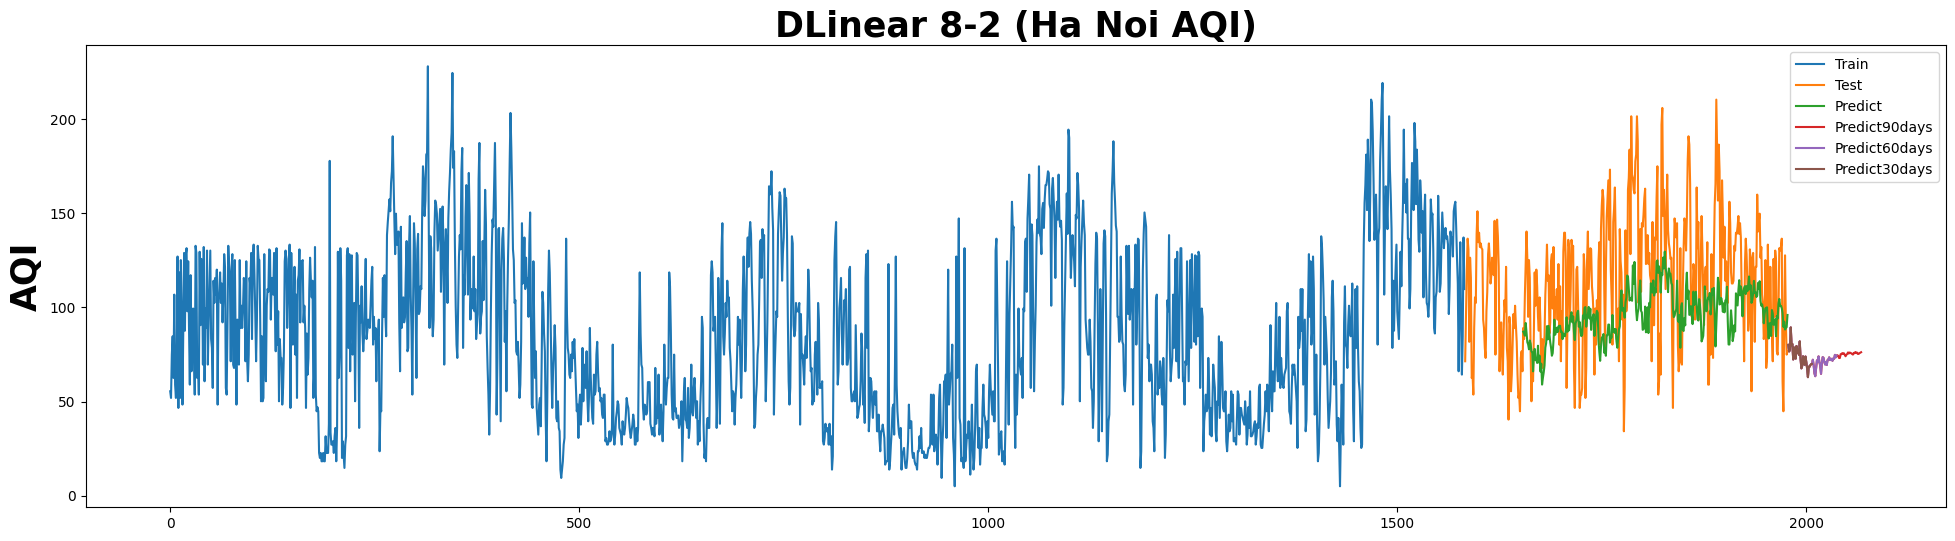

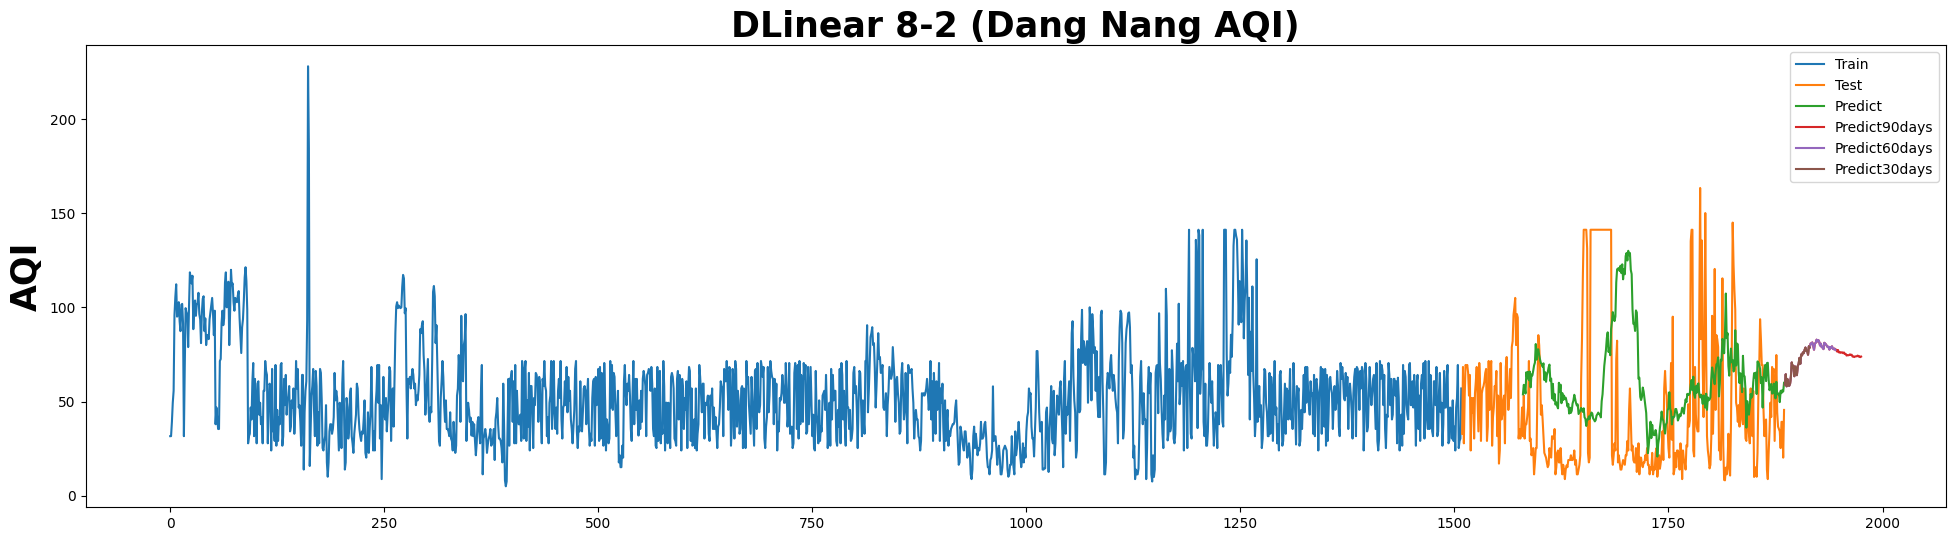

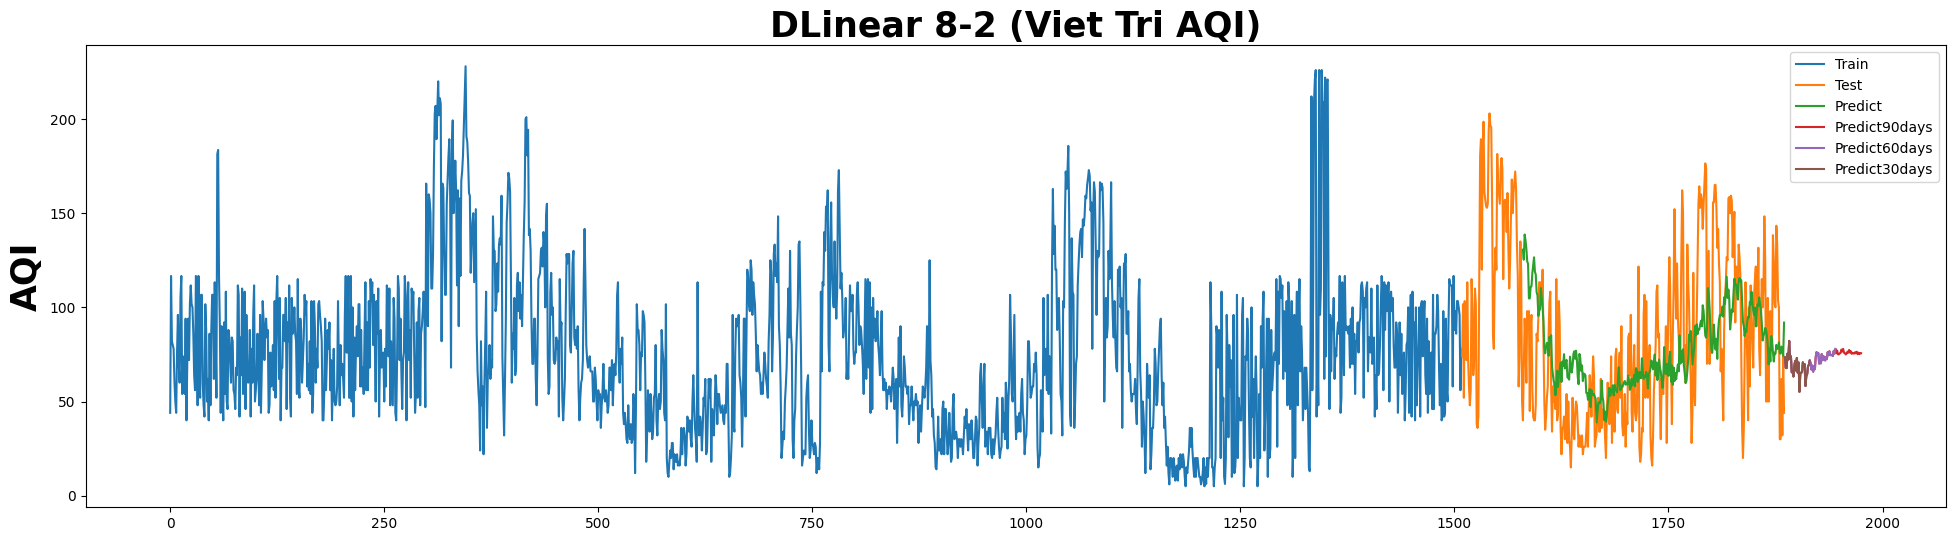

In [49]:
# Visualize the predictions
import matplotlib.pyplot as plt

## HaNoi
train_data_origin = scaler.inverse_transform(train_data_HaNoi)
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi
pred_30_origin = predictions_HaNoi_30
pred_60_origin = predictions_HaNoi_60
pred_90_origin = predictions_HaNoi_90


test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 8-2 (Ha Noi AQI)', fontsize=25, fontweight='bold')
plt.ylabel('AQI', fontsize=25, fontweight='bold')

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_8-2_HaNoi.png')


## DaNang
train_data_origin = scaler.inverse_transform(train_data_DaNang)
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang
pred_30_origin = predictions_DaNang_30
pred_60_origin = predictions_DaNang_60
pred_90_origin = predictions_DaNang_90

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 8-2 (Dang Nang AQI)', fontsize=25, fontweight='bold')
plt.ylabel('AQI', fontsize=25, fontweight='bold')

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_8-2_DaNang.png')
## VietTri
train_data_origin = scaler.inverse_transform(train_data_VietTri)
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri
pred_30_origin = predictions_VietTri_30
pred_60_origin = predictions_VietTri_60
pred_90_origin = predictions_VietTri_90

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 8-2 (Viet Tri AQI)', fontsize=25, fontweight='bold')
plt.ylabel('AQI', fontsize=25, fontweight='bold')

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_8-2_VietTri.png')



In [50]:
#tính RMSE,MAPE,MAE cho tâp test
from sklearn.metrics import mean_squared_error
from math import sqrt

## HaNoi
print('HaNoi')
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

print('DaNang')
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

## VietTri
print('VietTri')
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)


HaNoi
Test RMSE: 38.749
Test MAPE: 27.340
Test MAE: 31.648
DaNang
Test RMSE: 49.777
Test MAPE: 152.761
Test MAE: 40.453
VietTri
Test RMSE: 36.262
Test MAPE: 52.819
Test MAE: 29.225


### Với tỉ lệ 9 - 1

In [51]:
#splitting dataset into train and test split
split_size = 0.9

## HaNoi
train_size= int(split_size * len(df_Hanoi))
test_size = int((1-split_size) * len(df_Hanoi))

train_data_HaNoi = df1_HaNoi[:train_size]
test_data_HaNoi = df1_HaNoi[train_size:train_size+test_size]

## DaNang
train_size= int(split_size * len(df_DaNang))
test_size = int((1-split_size) * len(df_DaNang))

train_data_DaNang = df1_DaNang[:train_size]
test_data_DaNang = df1_DaNang[train_size:train_size+test_size]

## VietTri
train_size= int(split_size * len(df_VietTri))
test_size = int((1-split_size) * len(df_VietTri))

train_data_VietTri = df1_VietTri[:train_size]
test_data_VietTri = df1_VietTri[train_size:train_size+test_size]



In [52]:
#train model
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm
# Hyperparameters
seq_len = configs.seq_len  
pred_len =  configs.pred_len
batch_size = 64
num_epochs = 100
learning_rate = 0.003
individual = False


#fit model for HaNoi
model_HaNoi = fit(model, train_data_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for DaNang
model_DaNang = fit(model, train_data_DaNang, test_data_DaNang, seq_len, pred_len, batch_size, num_epochs, learning_rate)

#fit model for VietTri
model_VietTri = fit(model, train_data_VietTri, test_data_VietTri, seq_len, pred_len, batch_size, num_epochs, learning_rate)


c:\Users\Hung\miniconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [0/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0298]

Epoch 1/100, Train Loss: 0.0262, Test Loss: 0.0224


Epoch [0/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0298]


Epoch 2/100, Train Loss: 0.0253, Test Loss: 0.0225


Epoch [2/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0252]

Epoch 3/100, Train Loss: 0.0254, Test Loss: 0.0227


Epoch [2/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0252]


Epoch 4/100, Train Loss: 0.0251, Test Loss: 0.0224


Epoch [4/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.025] 

Epoch 5/100, Train Loss: 0.0251, Test Loss: 0.0222


Epoch [4/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.025]


Epoch 6/100, Train Loss: 0.0252, Test Loss: 0.0230


Epoch [6/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0218]

Epoch 7/100, Train Loss: 0.0250, Test Loss: 0.0230


Epoch [6/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0218]


Epoch 8/100, Train Loss: 0.0250, Test Loss: 0.0226


Epoch [8/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0265]

Epoch 9/100, Train Loss: 0.0251, Test Loss: 0.0228


Epoch [8/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0265]


Epoch 10/100, Train Loss: 0.0251, Test Loss: 0.0235


Epoch [10/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.026] 

Epoch 11/100, Train Loss: 0.0250, Test Loss: 0.0234


Epoch [10/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.026]


Epoch 12/100, Train Loss: 0.0248, Test Loss: 0.0231


Epoch [12/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.027] 

Epoch 13/100, Train Loss: 0.0248, Test Loss: 0.0225


Epoch [12/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.027]


Epoch 14/100, Train Loss: 0.0248, Test Loss: 0.0225


Epoch [14/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0251]

Epoch 15/100, Train Loss: 0.0247, Test Loss: 0.0225


Epoch [14/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0251]


Epoch 16/100, Train Loss: 0.0247, Test Loss: 0.0224


Epoch [16/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0234]

Epoch 17/100, Train Loss: 0.0247, Test Loss: 0.0235


Epoch [16/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0234]


Epoch 18/100, Train Loss: 0.0247, Test Loss: 0.0228


Epoch [18/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0251]

Epoch 19/100, Train Loss: 0.0246, Test Loss: 0.0222


Epoch [18/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0251]


Epoch 20/100, Train Loss: 0.0247, Test Loss: 0.0222


Epoch [20/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0225]

Epoch 21/100, Train Loss: 0.0246, Test Loss: 0.0231


Epoch [20/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0225]


Epoch 22/100, Train Loss: 0.0246, Test Loss: 0.0225


Epoch [22/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0277]

Epoch 23/100, Train Loss: 0.0246, Test Loss: 0.0220


Epoch [22/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0277]


Epoch 24/100, Train Loss: 0.0246, Test Loss: 0.0222


Epoch [24/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0277]

Epoch 25/100, Train Loss: 0.0247, Test Loss: 0.0224


Epoch [24/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0277]


Epoch 26/100, Train Loss: 0.0246, Test Loss: 0.0222


Epoch [26/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0199]

Epoch 27/100, Train Loss: 0.0246, Test Loss: 0.0224


Epoch [26/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0199]


Epoch 28/100, Train Loss: 0.0247, Test Loss: 0.0228


Epoch [28/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0244]

Epoch 29/100, Train Loss: 0.0246, Test Loss: 0.0229


Epoch [28/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0244]


Epoch 30/100, Train Loss: 0.0246, Test Loss: 0.0222


Epoch [30/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0272]

Epoch 31/100, Train Loss: 0.0246, Test Loss: 0.0224


Epoch [30/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0272]


Epoch 32/100, Train Loss: 0.0246, Test Loss: 0.0222


Epoch [32/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0215]

Epoch 33/100, Train Loss: 0.0245, Test Loss: 0.0228


Epoch [32/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0215]


Epoch 34/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [34/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0254]

Epoch 35/100, Train Loss: 0.0246, Test Loss: 0.0220


Epoch [34/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0254]


Epoch 36/100, Train Loss: 0.0245, Test Loss: 0.0224


Epoch [36/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0207]

Epoch 37/100, Train Loss: 0.0245, Test Loss: 0.0221


Epoch [36/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0207]


Epoch 38/100, Train Loss: 0.0245, Test Loss: 0.0225


Epoch [38/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.028] 

Epoch 39/100, Train Loss: 0.0246, Test Loss: 0.0221


Epoch [38/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.028]


Epoch 40/100, Train Loss: 0.0246, Test Loss: 0.0225


Epoch [40/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0245]

Epoch 41/100, Train Loss: 0.0246, Test Loss: 0.0225


Epoch [40/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0245]


Epoch 42/100, Train Loss: 0.0245, Test Loss: 0.0222


Epoch [42/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0228]

Epoch 43/100, Train Loss: 0.0245, Test Loss: 0.0225


Epoch [42/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0228]


Epoch 44/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [44/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.023] 

Epoch 45/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [44/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.023]


Epoch 46/100, Train Loss: 0.0246, Test Loss: 0.0226


Epoch [46/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0188]

Epoch 47/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [46/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0188]


Epoch 48/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [48/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0246]

Epoch 49/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [48/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0246]


Epoch 50/100, Train Loss: 0.0244, Test Loss: 0.0224


Epoch [50/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.021] 

Epoch 51/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [50/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.021]


Epoch 52/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [52/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0221]

Epoch 53/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [52/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0221]


Epoch 54/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [54/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0286]

Epoch 55/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [54/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0286]


Epoch 56/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [56/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0244]

Epoch 57/100, Train Loss: 0.0245, Test Loss: 0.0224


Epoch [56/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0244]


Epoch 58/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [58/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0227]

Epoch 59/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [58/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0227]


Epoch 60/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [60/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.027] 

Epoch 61/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [60/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.027]


Epoch 62/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [62/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0248]

Epoch 63/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [62/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0248]


Epoch 64/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [64/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0284]

Epoch 65/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [64/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0284]


Epoch 66/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [66/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0216]

Epoch 67/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [66/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0216]


Epoch 68/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [68/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0243]

Epoch 69/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [68/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0243]


Epoch 70/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [70/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0279]

Epoch 71/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [70/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0279]


Epoch 72/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [72/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.026] 

Epoch 73/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [72/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.026]


Epoch 74/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [74/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0226]

Epoch 75/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [74/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0226]


Epoch 76/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [76/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0225]

Epoch 77/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [76/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0225]


Epoch 78/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [78/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0248]

Epoch 79/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [78/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0248]


Epoch 80/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [80/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0261]

Epoch 81/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [80/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0261]


Epoch 82/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [82/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0225]

Epoch 83/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [82/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0225]


Epoch 84/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [84/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0219]

Epoch 85/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [84/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0219]


Epoch 86/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [86/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0233]

Epoch 87/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [86/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0233]


Epoch 88/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [88/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0203]

Epoch 89/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [88/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0203]


Epoch 90/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [90/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0274]

Epoch 91/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [90/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0274]


Epoch 92/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [92/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.023] 

Epoch 93/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [92/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.023]


Epoch 94/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [94/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.028] 

Epoch 95/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [94/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.028]


Epoch 96/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [96/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0243]

Epoch 97/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [96/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0243]


Epoch 98/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [98/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0233]

Epoch 99/100, Train Loss: 0.0244, Test Loss: 0.0223


Epoch [99/100]:   0%|          | 0/27 [00:00<?, ?it/s, loss=0.0268]


Epoch 100/100, Train Loss: 0.0245, Test Loss: 0.0223


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.014]  

Epoch 1/100, Train Loss: 0.0128, Test Loss: 0.0273


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.014]


Epoch 2/100, Train Loss: 0.0119, Test Loss: 0.0275


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111] 

Epoch 3/100, Train Loss: 0.0118, Test Loss: 0.0279


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0111]


Epoch 4/100, Train Loss: 0.0117, Test Loss: 0.0280


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.008]  

Epoch 5/100, Train Loss: 0.0117, Test Loss: 0.0278


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.008]


Epoch 6/100, Train Loss: 0.0118, Test Loss: 0.0280


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0123] 

Epoch 7/100, Train Loss: 0.0117, Test Loss: 0.0280


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0123]


Epoch 8/100, Train Loss: 0.0116, Test Loss: 0.0280


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0115] 

Epoch 9/100, Train Loss: 0.0116, Test Loss: 0.0281


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0115]


Epoch 10/100, Train Loss: 0.0116, Test Loss: 0.0279


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0142] 

Epoch 11/100, Train Loss: 0.0117, Test Loss: 0.0279


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0142]


Epoch 12/100, Train Loss: 0.0116, Test Loss: 0.0280


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0101] 

Epoch 13/100, Train Loss: 0.0117, Test Loss: 0.0281


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0101]


Epoch 14/100, Train Loss: 0.0116, Test Loss: 0.0281


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0156] 

Epoch 15/100, Train Loss: 0.0116, Test Loss: 0.0284


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0156]


Epoch 16/100, Train Loss: 0.0115, Test Loss: 0.0281


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0106] 

Epoch 17/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0106]


Epoch 18/100, Train Loss: 0.0116, Test Loss: 0.0281


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.012]  

Epoch 19/100, Train Loss: 0.0116, Test Loss: 0.0281


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.012]


Epoch 20/100, Train Loss: 0.0115, Test Loss: 0.0281


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00965]

Epoch 21/100, Train Loss: 0.0115, Test Loss: 0.0281


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00965]


Epoch 22/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0107] 

Epoch 23/100, Train Loss: 0.0115, Test Loss: 0.0281


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0107]


Epoch 24/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0106] 

Epoch 25/100, Train Loss: 0.0115, Test Loss: 0.0281


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0106]


Epoch 26/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0156] 

Epoch 27/100, Train Loss: 0.0116, Test Loss: 0.0280


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0156]


Epoch 28/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00977]

Epoch 29/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00977]


Epoch 30/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00936]

Epoch 31/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00936]


Epoch 32/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0222] 

Epoch 33/100, Train Loss: 0.0117, Test Loss: 0.0281


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0222]


Epoch 34/100, Train Loss: 0.0116, Test Loss: 0.0280


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0133] 

Epoch 35/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0133]


Epoch 36/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0135] 

Epoch 37/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0135]


Epoch 38/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00878]

Epoch 39/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00878]


Epoch 40/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00828]

Epoch 41/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00828]


Epoch 42/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0104] 

Epoch 43/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0104]


Epoch 44/100, Train Loss: 0.0117, Test Loss: 0.0280


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00832]

Epoch 45/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00832]


Epoch 46/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.013]  

Epoch 47/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.013]


Epoch 48/100, Train Loss: 0.0116, Test Loss: 0.0280


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0137] 

Epoch 49/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0137]


Epoch 50/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0104] 

Epoch 51/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0104]


Epoch 52/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0131] 

Epoch 53/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0131]


Epoch 54/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00756]

Epoch 55/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00756]


Epoch 56/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00694]

Epoch 57/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00694]


Epoch 58/100, Train Loss: 0.0116, Test Loss: 0.0280


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0113] 

Epoch 59/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0113]


Epoch 60/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00919]

Epoch 61/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00919]


Epoch 62/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0122] 

Epoch 63/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0122]


Epoch 64/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0101] 

Epoch 65/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0101]


Epoch 66/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00896]

Epoch 67/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00896]


Epoch 68/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00788]

Epoch 69/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00788]


Epoch 70/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0146] 

Epoch 71/100, Train Loss: 0.0116, Test Loss: 0.0280


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0146]


Epoch 72/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00813]

Epoch 73/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00813]


Epoch 74/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00951]

Epoch 75/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00951]


Epoch 76/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0118] 

Epoch 77/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0118]


Epoch 78/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00733]

Epoch 79/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00733]


Epoch 80/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00847]

Epoch 81/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00847]


Epoch 82/100, Train Loss: 0.0116, Test Loss: 0.0280


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00973]

Epoch 83/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00973]


Epoch 84/100, Train Loss: 0.0117, Test Loss: 0.0280


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0101] 

Epoch 85/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0101]


Epoch 86/100, Train Loss: 0.0117, Test Loss: 0.0280


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124] 

Epoch 87/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0124]


Epoch 88/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00763]

Epoch 89/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00763]


Epoch 90/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00574]

Epoch 91/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00574]


Epoch 92/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00905]

Epoch 93/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00905]


Epoch 94/100, Train Loss: 0.0117, Test Loss: 0.0280


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0172] 

Epoch 95/100, Train Loss: 0.0116, Test Loss: 0.0280


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0172]


Epoch 96/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0076] 

Epoch 97/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0076]


Epoch 98/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [98/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.00921]

Epoch 99/100, Train Loss: 0.0114, Test Loss: 0.0280


Epoch [99/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0135]


Epoch 100/100, Train Loss: 0.0115, Test Loss: 0.0280


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0399]

Epoch 1/100, Train Loss: 0.0280, Test Loss: 0.0335


Epoch [0/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0399]


Epoch 2/100, Train Loss: 0.0258, Test Loss: 0.0329


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0194]

Epoch 3/100, Train Loss: 0.0255, Test Loss: 0.0325


Epoch [2/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0194]


Epoch 4/100, Train Loss: 0.0255, Test Loss: 0.0340


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0186]

Epoch 5/100, Train Loss: 0.0254, Test Loss: 0.0333


Epoch [4/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0186]


Epoch 6/100, Train Loss: 0.0255, Test Loss: 0.0307


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.017] 

Epoch 7/100, Train Loss: 0.0253, Test Loss: 0.0331


Epoch [6/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.017]


Epoch 8/100, Train Loss: 0.0257, Test Loss: 0.0341


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0213]

Epoch 9/100, Train Loss: 0.0254, Test Loss: 0.0332


Epoch [8/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0213]


Epoch 10/100, Train Loss: 0.0259, Test Loss: 0.0305


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0279]

Epoch 11/100, Train Loss: 0.0258, Test Loss: 0.0326


Epoch [10/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0279]


Epoch 12/100, Train Loss: 0.0257, Test Loss: 0.0314


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.022] 

Epoch 13/100, Train Loss: 0.0256, Test Loss: 0.0307


Epoch [12/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.022]


Epoch 14/100, Train Loss: 0.0255, Test Loss: 0.0322


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.032] 

Epoch 15/100, Train Loss: 0.0257, Test Loss: 0.0308


Epoch [14/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.032]


Epoch 16/100, Train Loss: 0.0258, Test Loss: 0.0307


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.026] 

Epoch 17/100, Train Loss: 0.0252, Test Loss: 0.0321


Epoch [16/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.026]


Epoch 18/100, Train Loss: 0.0253, Test Loss: 0.0325


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0233]

Epoch 19/100, Train Loss: 0.0251, Test Loss: 0.0318


Epoch [18/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0233]


Epoch 20/100, Train Loss: 0.0252, Test Loss: 0.0316


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0218]

Epoch 21/100, Train Loss: 0.0251, Test Loss: 0.0317


Epoch [20/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0218]


Epoch 22/100, Train Loss: 0.0255, Test Loss: 0.0308


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0306]

Epoch 23/100, Train Loss: 0.0251, Test Loss: 0.0328


Epoch [22/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0306]


Epoch 24/100, Train Loss: 0.0251, Test Loss: 0.0316


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0257]

Epoch 25/100, Train Loss: 0.0250, Test Loss: 0.0313


Epoch [24/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0257]


Epoch 26/100, Train Loss: 0.0252, Test Loss: 0.0311


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0248]

Epoch 27/100, Train Loss: 0.0251, Test Loss: 0.0312


Epoch [26/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0248]


Epoch 28/100, Train Loss: 0.0255, Test Loss: 0.0309


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.024] 

Epoch 29/100, Train Loss: 0.0250, Test Loss: 0.0319


Epoch [28/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.024]


Epoch 30/100, Train Loss: 0.0249, Test Loss: 0.0319


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0308]

Epoch 31/100, Train Loss: 0.0251, Test Loss: 0.0311


Epoch [30/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0308]


Epoch 32/100, Train Loss: 0.0249, Test Loss: 0.0319


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0194]

Epoch 33/100, Train Loss: 0.0248, Test Loss: 0.0320


Epoch [32/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0194]


Epoch 34/100, Train Loss: 0.0250, Test Loss: 0.0315


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0167]

Epoch 35/100, Train Loss: 0.0247, Test Loss: 0.0317


Epoch [34/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0167]


Epoch 36/100, Train Loss: 0.0249, Test Loss: 0.0314


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0233]

Epoch 37/100, Train Loss: 0.0249, Test Loss: 0.0317


Epoch [36/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0233]


Epoch 38/100, Train Loss: 0.0252, Test Loss: 0.0314


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0322]

Epoch 39/100, Train Loss: 0.0251, Test Loss: 0.0316


Epoch [38/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0322]


Epoch 40/100, Train Loss: 0.0249, Test Loss: 0.0318


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0205]

Epoch 41/100, Train Loss: 0.0248, Test Loss: 0.0317


Epoch [40/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0205]


Epoch 42/100, Train Loss: 0.0248, Test Loss: 0.0315


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.027] 

Epoch 43/100, Train Loss: 0.0249, Test Loss: 0.0314


Epoch [42/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.027]


Epoch 44/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0294]

Epoch 45/100, Train Loss: 0.0250, Test Loss: 0.0317


Epoch [44/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0294]


Epoch 46/100, Train Loss: 0.0249, Test Loss: 0.0317


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0207]

Epoch 47/100, Train Loss: 0.0248, Test Loss: 0.0315


Epoch [46/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0207]


Epoch 48/100, Train Loss: 0.0249, Test Loss: 0.0316


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0308]

Epoch 49/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [48/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0308]


Epoch 50/100, Train Loss: 0.0249, Test Loss: 0.0315


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0291]

Epoch 51/100, Train Loss: 0.0250, Test Loss: 0.0315


Epoch [50/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0291]


Epoch 52/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0185]

Epoch 53/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [52/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0185]


Epoch 54/100, Train Loss: 0.0249, Test Loss: 0.0316


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0317]

Epoch 55/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [54/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0317]


Epoch 56/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0205]

Epoch 57/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [56/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0205]


Epoch 58/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0319]

Epoch 59/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [58/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0319]


Epoch 60/100, Train Loss: 0.0249, Test Loss: 0.0316


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0177]

Epoch 61/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [60/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0177]


Epoch 62/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0174]

Epoch 63/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [62/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0174]


Epoch 64/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0155]

Epoch 65/100, Train Loss: 0.0246, Test Loss: 0.0316


Epoch [64/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0155]


Epoch 66/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0175]

Epoch 67/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [66/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0175]


Epoch 68/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0199]

Epoch 69/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [68/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0199]


Epoch 70/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0326]

Epoch 71/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [70/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0326]


Epoch 72/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.022] 

Epoch 73/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [72/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.022]


Epoch 74/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0284]

Epoch 75/100, Train Loss: 0.0249, Test Loss: 0.0316


Epoch [74/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0284]


Epoch 76/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0221]

Epoch 77/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [76/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0221]


Epoch 78/100, Train Loss: 0.0249, Test Loss: 0.0316


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0265]

Epoch 79/100, Train Loss: 0.0249, Test Loss: 0.0316


Epoch [78/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0265]


Epoch 80/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0318]

Epoch 81/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [80/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0318]


Epoch 82/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0233]

Epoch 83/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [82/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0233]


Epoch 84/100, Train Loss: 0.0249, Test Loss: 0.0316


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0252]

Epoch 85/100, Train Loss: 0.0249, Test Loss: 0.0316


Epoch [84/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0252]


Epoch 86/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0266]

Epoch 87/100, Train Loss: 0.0249, Test Loss: 0.0316


Epoch [86/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0266]


Epoch 88/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0258]

Epoch 89/100, Train Loss: 0.0249, Test Loss: 0.0316


Epoch [88/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0258]


Epoch 90/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0183]

Epoch 91/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [90/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0183]


Epoch 92/100, Train Loss: 0.0249, Test Loss: 0.0316


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0329]

Epoch 93/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [92/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0329]


Epoch 94/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0214]

Epoch 95/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [94/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0214]


Epoch 96/100, Train Loss: 0.0250, Test Loss: 0.0316


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0189]

Epoch 97/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [96/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0189]


Epoch 98/100, Train Loss: 0.0248, Test Loss: 0.0316


Epoch [98/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0177]

Epoch 99/100, Train Loss: 0.0247, Test Loss: 0.0316


Epoch [99/100]:   0%|          | 0/26 [00:00<?, ?it/s, loss=0.0297]

Epoch 100/100, Train Loss: 0.0250, Test Loss: 0.0316


In [53]:
# Make predictions on the test data
test_pred_HaNoi = predict_test(model_HaNoi, test_data_HaNoi, seq_len, pred_len, batch_size)
test_pred_DaNang = predict_test(model_DaNang, test_data_DaNang, seq_len, pred_len, batch_size)
test_pred_VietTri = predict_test(model_VietTri, test_data_VietTri, seq_len, pred_len, batch_size)
# Inverse transform the predictions
test_pred_HaNoi = scaler.inverse_transform(test_pred_HaNoi)
test_pred_DaNang = scaler.inverse_transform(test_pred_DaNang)
test_pred_VietTri = scaler.inverse_transform(test_pred_VietTri)


In [54]:
## Make predictions for the next 30 days
prediction_days = 30
predictions_HaNoi_30 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_30 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_30 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_30 = scaler.inverse_transform(predictions_HaNoi_30)
predictions_DaNang_30 = scaler.inverse_transform(predictions_DaNang_30)
predictions_VietTri_30 = scaler.inverse_transform(predictions_VietTri_30)

## Make predictions for the next 60 days
prediction_days = 60
predictions_HaNoi_60 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_60 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_60 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_60 = scaler.inverse_transform(predictions_HaNoi_60)
predictions_DaNang_60 = scaler.inverse_transform(predictions_DaNang_60)
predictions_VietTri_60 = scaler.inverse_transform(predictions_VietTri_60)

## Make predictions for the next 90 days

prediction_days = 90
predictions_HaNoi_90 = predict(model_HaNoi, test_data_HaNoi, configs.seq_len, prediction_days)
predictions_DaNang_90 = predict(model_DaNang, test_data_DaNang, configs.seq_len, prediction_days)
predictions_VietTri_90 = predict(model_VietTri, test_data_VietTri, configs.seq_len, prediction_days)

# Inverse transform the predictions
predictions_HaNoi_90 = scaler.inverse_transform(predictions_HaNoi_90)
predictions_DaNang_90 = scaler.inverse_transform(predictions_DaNang_90)
predictions_VietTri_90 = scaler.inverse_transform(predictions_VietTri_90)


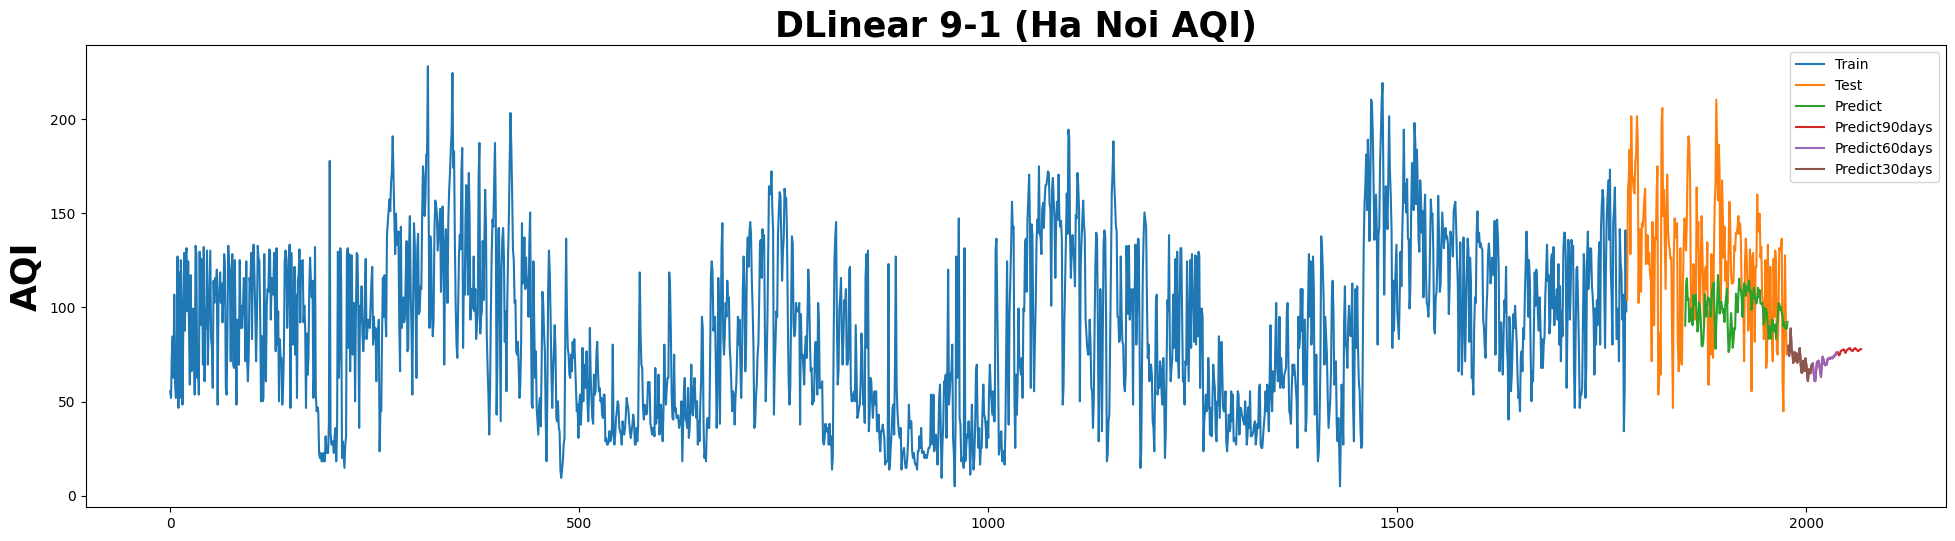

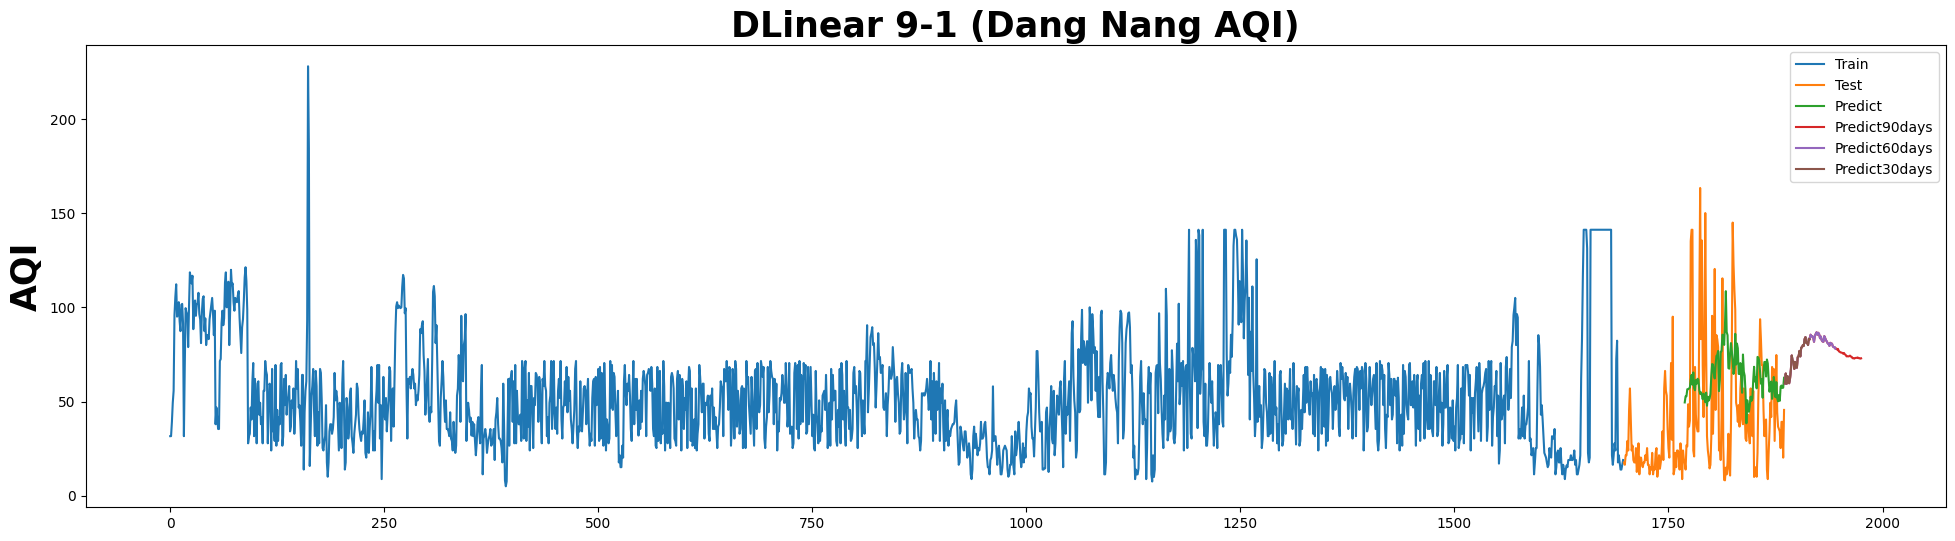

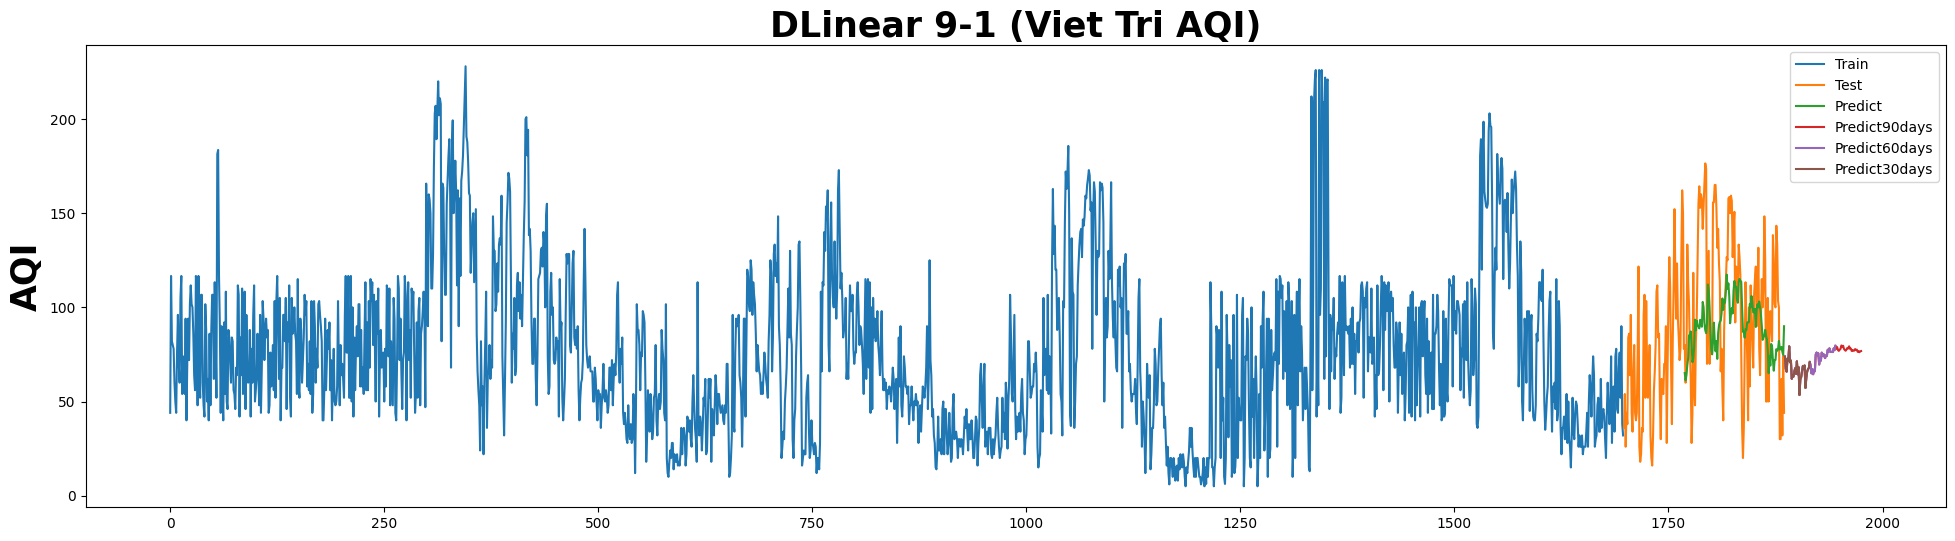

In [55]:
# Visualize the predictions
import matplotlib.pyplot as plt

## HaNoi
train_data_origin = scaler.inverse_transform(train_data_HaNoi)
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi
pred_30_origin = predictions_HaNoi_30
pred_60_origin = predictions_HaNoi_60
pred_90_origin = predictions_HaNoi_90


test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 9-1 (Ha Noi AQI)', fontsize=25, fontweight='bold')
plt.ylabel('AQI', fontsize=25, fontweight='bold')

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_9-1_HaNoi.png')

## DaNang
train_data_origin = scaler.inverse_transform(train_data_DaNang)
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang
pred_30_origin = predictions_DaNang_30
pred_60_origin = predictions_DaNang_60
pred_90_origin = predictions_DaNang_90

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 9-1 (Dang Nang AQI)', fontsize=25, fontweight='bold')
plt.ylabel('AQI', fontsize=25, fontweight='bold')

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_9-1_DaNang.png')

## VietTri
train_data_origin = scaler.inverse_transform(train_data_VietTri)
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri
pred_30_origin = predictions_VietTri_30
pred_60_origin = predictions_VietTri_60
pred_90_origin = predictions_VietTri_90

test_data_index = pd.RangeIndex(start=len(train_data_origin), stop=len(train_data_origin)+len(test_data_origin), step=1)
test_pred_index = pd.RangeIndex(start=len(train_data_origin)+configs.seq_len+configs.pred_len-1, stop=len(train_data_origin)+len(test_data_origin), step=1)
pred_30_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+30, step=1)
pred_60_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+60, step=1)
pred_90_index = pd.RangeIndex(start=len(train_data_origin)+len(test_data_origin), stop=len(train_data_origin)+len(test_data_origin)+90, step=1)

plt.figure(figsize=(24, 6))
plt.title('DLinear 9-1 (Viet Tri AQI)', fontsize=25, fontweight='bold')
plt.ylabel('AQI', fontsize=25, fontweight='bold')

plt.plot(train_data_origin)
plt.plot(test_data_index, test_data_origin)
plt.plot(test_pred_index, test_pred_origin)
plt.plot(pred_90_index, pred_90_origin)
plt.plot(pred_60_index, pred_60_origin)
plt.plot(pred_30_index, pred_30_origin)

plt.legend(['Train','Test','Predict','Predict90days','Predict60days','Predict30days'])
#Save plot to file
plt.savefig('plot/DLinear_9-1_VietTri.png')



In [56]:
#tính RMSE,MAPE,MAE cho tâp test
from sklearn.metrics import mean_squared_error
from math import sqrt

## HaNoi
print('HaNoi')
test_data_origin = scaler.inverse_transform(test_data_HaNoi)
test_pred_origin = test_pred_HaNoi

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

print('DaNang')
test_data_origin = scaler.inverse_transform(test_data_DaNang)
test_pred_origin = test_pred_DaNang

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)

## VietTri
print('VietTri')
test_data_origin = scaler.inverse_transform(test_data_VietTri)
test_pred_origin = test_pred_VietTri

test_data_origin_1 = test_data_origin[configs.seq_len+configs.pred_len-1:]
rmse = sqrt(mean_squared_error(test_pred_origin, test_data_origin_1))
mape = np.mean(np.abs((test_pred_origin - test_data_origin_1) /test_data_origin_1)) * 100
mae = np.mean(np.abs(test_pred_origin - test_data_origin_1))
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)
print('Test MAE: %.3f' % mae)


HaNoi
Test RMSE: 38.120
Test MAPE: 24.913
Test MAE: 30.357
DaNang
Test RMSE: 39.035
Test MAPE: 123.400
Test MAE: 31.564
VietTri
Test RMSE: 40.654
Test MAPE: 40.163
Test MAE: 33.197
